# Introduction: Playing in Starbucks' Sandbox

This notebook is the code-level result of my exploration of a simulated dataset created by Starbucks, which I have affectionately termed their sandbox.  I suggest you read the (slightly) higher-level view of the results in one or both of the accompanying blog posts - [the more readable narrative version](https://chapman-mcdaniel.medium.com/playing-in-starbucks-sandbox-b8937293fa78) and [the version structured around the rubric](https://chapman-mcdaniel.medium.com/nanodegree-capstone-project-starbucks-acb4cb65efed) before exploring this notebook, since only some of the context from the post will be repeated here.

The original problem statement and general overview is contained in the repository's README.md file.  As a one-sentence overview, the dataset tracks a test of discount offers sent to the customers of a fictional coffee company, which I have decided is named Stuckbars.

Exploratory data analysis throws off a very large number of graphs, which weigh down the browser displaying the notebook.  As a result, many of them are commented out in this final version for notebook display reasons - leaving only a selection to communicate key findings or to give general ideas of what the plots look like.  Simply uncomment to view others if desired.

Only a few more elements to discuss up front:

- The sources showing the profit margin of 25% used in this analysis are [this post from visual capitalist](https://www.visualcapitalist.com/the-economics-of-coffee-in-one-chart/) and Starbucks' own [2019 Annual Report](https://investor.starbucks.com/financial-data/annual-reports/default.aspx) (showing 20% margin in the Americas, but this includes marketing cost).  For this analysis we need the profit margin excluding marketing cost, because the objective of the project is to optimize marketing cost.


- The problem statement gives the offer's influence period as the duration, but here we primarily use 10-days.  This is to give a more reasonable comparison across the offers, and because of the difficulty of setting an influence duration for the 'no offer' option.  A comparison between the results for a 10-day influence period and a duration-based influence period is given.

- This notebook contains the exploratory data analysis.  The machine learning application is in a separate notebook.


---------

# Objective

The primary objective mentioned in the blog post bears repeating here:

_**The objective is to determine the best offer to present to each customer**_ 

_**The best offer is the one that yields maximum return for Stuckbars.**_

---------

# Data Dictionary

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_context('talk')
%matplotlib inline
palette = sns.color_palette()

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Portfolio Dataset

In [2]:
#take a look at the dataframe
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
# add a nickname to reference offers by
                        # take the first 4 chars of the type
portfolio['nickname'] = ((portfolio.offer_type.str.slice(stop=4) + "-")
                                #concatenate in the difficulty
                                 .str.cat([portfolio.difficulty.astype(str)]).str.cat(
                                     # the reward
                                     [portfolio.reward.astype(str),
                                      # and the duration
                                      portfolio.duration.astype(str)], sep='/'))

In [4]:
# create a version of the portfolio with a shorter uniqueid to print for the blog post
portfolio_disp = portfolio.copy()
portfolio_disp['id'] = portfolio_disp.id.str.slice(stop=15) + " ..."
# display the desired columns in the desired order
(portfolio_disp[['id', 'offer_type', 'channels', 'difficulty', 'reward', 'duration', 'nickname']]
 .sort_values(['offer_type', 'difficulty', 'duration'])).reset_index().drop(columns='index')

,id,offer_type,channels,difficulty,reward,duration,nickname
0,f19421c1d4aa409 ...,bogo,"[web, email, mobile, social]",5,5,5,bogo-5/5/5
1,9b98b8c7a33c4b6 ...,bogo,"[web, email, mobile]",5,5,7,bogo-5/5/7
2,4d5c57ea9a6940d ...,bogo,"[web, email, mobile, social]",10,10,5,bogo-10/10/5
3,ae264e3637204a6 ...,bogo,"[email, mobile, social]",10,10,7,bogo-10/10/7
4,2298d6c36e964ae ...,discount,"[web, email, mobile, social]",7,3,7,disc-7/3/7
5,2906b810c7d4411 ...,discount,"[web, email, mobile]",10,2,7,disc-10/2/7
6,fafdcd668e3743c ...,discount,"[web, email, mobile, social]",10,2,10,disc-10/2/10
7,0b1e1539f2cc45b ...,discount,"[web, email]",20,5,10,disc-20/5/10
8,5a8bc65990b245e ...,informational,"[email, mobile, social]",0,0,3,info-0/0/3
9,3f207df678b143e ...,informational,"[web, email, mobile]",0,0,4,info-0/0/4


In [5]:
# process the channels information to one-hot encode it
for channel in ['web', 'email', 'mobile', 'social']:
    output_name = "channel_" + channel
    portfolio.loc[:,output_name] = portfolio.loc[:, 'channels'].map(lambda x: channel in x)

# drop original channels column
portfolio.drop(columns='channels', inplace=True)
portfolio

,reward,difficulty,duration,offer_type,id,nickname,channel_web,channel_email,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10/10/7,False,True,True,True
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10/10/5,True,True,True,True
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,info-0/0/4,True,True,True,False
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5/5/7,True,True,True,False
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,disc-20/5/10,True,True,False,False
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,disc-7/3/7,True,True,True,True
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,disc-10/2/10,True,True,True,True
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,info-0/0/3,False,True,True,True
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo-5/5/5,True,True,True,True
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,disc-10/2/7,True,True,True,False


# Profiles Dataset

In [6]:
# info about the user profiles dataframe
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
# create a version of the profiles dataframe with shortened ID for posting
profile_disp = profile.copy().head(10)
nicknames = ['Lipe', 'Fulana', 'Lucas', 'Zoe', 'Angela']
profile_disp['id'] = profile_disp.id.str.slice(stop=9) + " ... (" + pd.Series(nicknames) + ")"
profile_disp[['id', 'became_member_on', 'age', 'gender', 'income']].head()

,id,became_member_on,age,gender,income
0,68be06ca3 ... (Lipe),20170212,118,None,NaN
1,0610b4864 ... (Fulana),20170715,55,F,112000.0
2,38fe809ad ... (Lucas),20180712,118,None,NaN
3,78afa9957 ... (Zoe),20170509,75,F,100000.0
4,a03223e63 ... (Angela),20170804,118,None,NaN


In [8]:
# Convert became_member_on to datetime and tranform into to days_of_membership (more model-friendly)
profile['became_member_on'] = pd.to_datetime(profile.became_member_on, format="%Y%m%d")
profile['days_of_membership'] = (pd.to_datetime(profile.became_member_on.max()) - profile.became_member_on).dt.days

In [9]:
# Print different statistics about the profiles data to understand missing values

print("Number of profiles with gender = NaN:", profile.gender.isna().sum())
print("Number of profiles with income = NaN:", profile.income.isna().sum())
print("Number of profiles with income and gender = NaN:", 
      profile[(profile.gender.isna()) & (profile.income.isna())].shape[0])
print("Number of profiles with age = NaN:", profile.age.isna().sum())
print("Ages of profiles with gender = NaN:", profile[profile.gender.isna()]['age'].unique())
print()
print("Newest member join date:", profile.became_member_on.max())
print("Oldest member join date:", profile.became_member_on.min())

Number of profiles with gender = NaN: 2175
Number of profiles with income = NaN: 2175
Number of profiles with income and gender = NaN: 2175
Number of profiles with age = NaN: 0
Ages of profiles with gender = NaN: [118]

Newest member join date: 2018-07-26 00:00:00
Oldest member join date: 2013-07-29 00:00:00


In [10]:
# It seems that a certain percentage of profiles are simply anonymous - all we have is a join date
# This can also be useful information, so capture it in another column
profile['anonymous'] = profile.gender.isna()

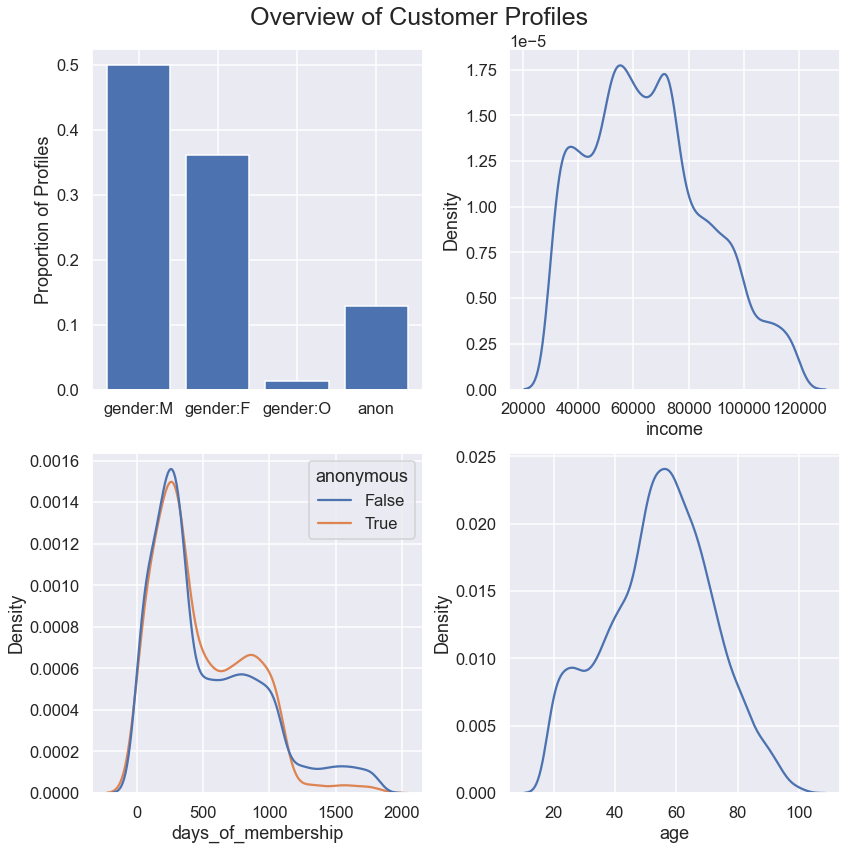

In [11]:
# plot key statics and overview distributions of the customer base

f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
axs=axs.flatten()
# proportions in first plot
prop_male = (profile.gender == 'M').sum() / profile.shape[0]
prop_female = (profile.gender == 'F').sum() / profile.shape[0]
prop_other = (profile.gender == 'O').sum() / profile.shape[0]
prop_anon = profile.anonymous.sum() / profile.shape[0]
axs[0].bar(['gender:M', 'gender:F', 'gender:O', 'anon'], [prop_male, prop_female, prop_other, prop_anon])
axs[0].set(ylabel='Proportion of Profiles')

# income in second plot
sns.kdeplot(data=profile, x='income', ax=axs[1])

# membership length in third plot
sns.kdeplot(data=profile, x='days_of_membership', hue='anonymous', ax=axs[2], common_norm=False)

# age in fourth plot
sns.kdeplot(data=profile[~profile.anonymous], x='age', ax=axs[3])
f.suptitle('Overview of Customer Profiles', fontsize=25)
plt.tight_layout();
plt.savefig('./images/Profile_Overview.png', dpi=600)

In [12]:
# Bar for gender:Other is too small to see properly - print to show
print("Proportion of customers with gender:Other:", prop_other)

Proportion of customers with gender:Other: 0.012470588235294117


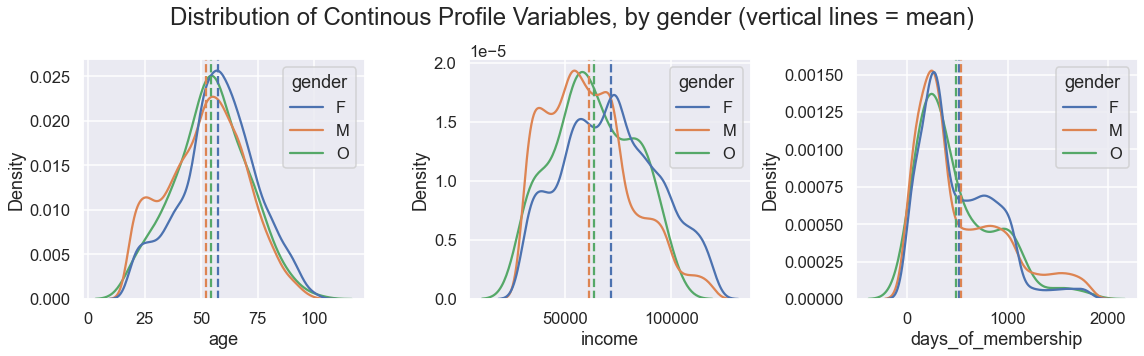

In [13]:
# Distributions of all continuous variables by gender
f, axs = plt.subplots(ncols=3, figsize=(16,5))
axs = axs.flatten()

# Plot the distributions
sns.kdeplot(data=profile, x='age', hue='gender', common_norm=False, ax=axs[0])
sns.kdeplot(data=profile, x='income', hue='gender', common_norm=False, ax=axs[1])
sns.kdeplot(data=profile, x='days_of_membership', hue='gender', common_norm=False, ax=axs[2])
f.suptitle('Distribution of Continous Profile Variables, by gender (vertical lines = mean)', fontsize=24)

# plot the means of each distribution as vertical lines
for i, facet in enumerate(['age', 'income', 'days_of_membership']):
    for j, k in enumerate(profile.groupby('gender')[facet].mean()):
        axs[i].axvline(k, color=palette[j], ls='--')
plt.tight_layout();

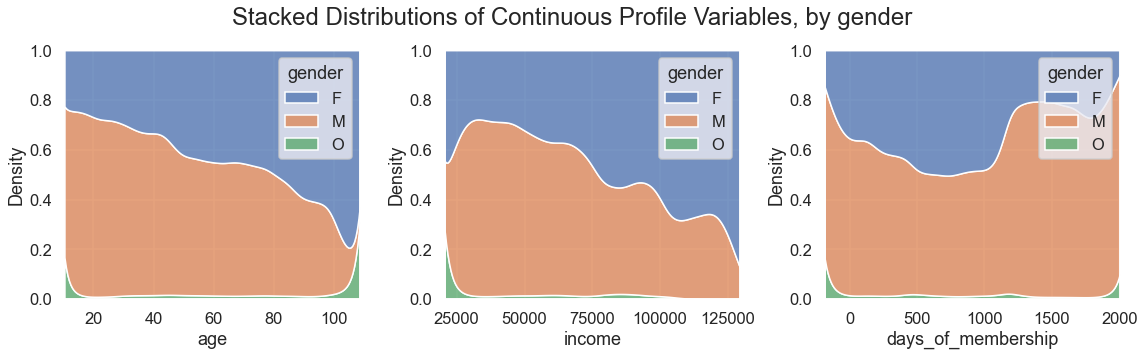

In [14]:
# Stacked distributions of continuous variables by gender
# (stacked version of the plot above)
f, axs = plt.subplots(ncols=3, figsize=(16,5))
axs = axs.flatten()

sns.kdeplot(data=profile, x='age', hue='gender', multiple='fill', ax=axs[0])
sns.kdeplot(data=profile, x='income', hue='gender', multiple='fill', ax=axs[1])
sns.kdeplot(data=profile, x='days_of_membership', hue='gender', multiple='fill', ax=axs[2])
f.suptitle('Stacked Distributions of Continuous Profile Variables, by gender', fontsize=24)
plt.tight_layout()
plt.savefig('./images/Continuous_Vars_by_Gender.png', dpi=600);

In [15]:
# Stacked distributions of days of membership by whether user is anonymous or not (same plot as above)
# Commented out as not particularly illustrative - uncomment and run to view

#f, ax = plt.subplots(figsize=(8,6))
#sns.kdeplot(data=profile, x='days_of_membership', hue='anonymous', multiple='fill');
#f.suptitle('Stacked Distributions of Membership Length', fontsize=18);

## Transcript

In [16]:
# Basic info - fully populated
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [17]:
# Examine structure of transcript dataframe - this person completes two offers with the same transaction
random_person = transcript.person.iloc[50]
transcript_disp = transcript[transcript.person == random_person].copy()
transcript_disp['person'] = transcript_disp.person.str.slice(stop=15) + " ..."
transcript_disp

,person,event,value,time
50,fb98ebe9e3e14af ...,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
45437,fb98ebe9e3e14af ...,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},120
53227,fb98ebe9e3e14af ...,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},168
88893,fb98ebe9e3e14af ...,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},228
110880,fb98ebe9e3e14af ...,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336
123554,fb98ebe9e3e14af ...,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},336
150650,fb98ebe9e3e14af ...,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},408
171224,fb98ebe9e3e14af ...,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},420
201622,fb98ebe9e3e14af ...,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},504
232885,fb98ebe9e3e14af ...,transaction,{'amount': 33.38},540


In [18]:
# Examine structure of transcript dataframe - this person completes an offer before viewing it
random_person = transcript.person.iloc[14]
transcript_disp = transcript[transcript.person == random_person].copy()
transcript_disp['person'] = transcript_disp.person.str.slice(stop=9) + "  ... (Elias)"
transcript_disp

,person,event,value,time
14,d53717f54 ... (Elias),offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
25736,d53717f54 ... (Elias),offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},30
25737,d53717f54 ... (Elias),transaction,{'amount': 339.69},30
25738,d53717f54 ... (Elias),offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,30
29172,d53717f54 ... (Elias),transaction,{'amount': 9.97},42
32321,d53717f54 ... (Elias),transaction,{'amount': 10.57},54
76724,d53717f54 ... (Elias),transaction,{'amount': 21.26},186
91803,d53717f54 ... (Elias),transaction,{'amount': 9.81},234
110842,d53717f54 ... (Elias),offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336
145007,d53717f54 ... (Elias),offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},384


In [19]:
# The dictionary in the 'value' column is more useful as its individual elements,
# even though they will have significant NaNs

# Pull offer id, completion reward, and transaction amounts out using helper functions

def get_offer_id(value_col):
    """
    Function indended to be applied to the transcript.value column via Series.apply
    to extract the offer ID,
    
    Parameters:
    value_col: (dict) a value from the pandas series transcript.value
    
    returns: (string) offer_id if the row contains an offer, np.NaN if not
    """
    
    # Some of the rows store offer id as 'offer id' with a space
    if 'offer id' in value_col.keys():
        offer_id = value_col['offer id']
    # Other rows store it with an underscore
    elif 'offer_id' in value_col.keys():
        offer_id = value_col['offer_id']
    # Some rows are transactions and do not refer to an offer
    else:
        offer_id = np.NaN
    
    return offer_id


def get_amount(value_col):
    """
    Function intended to be applied to the transcript.value column via Series.apply
    to extract the transaction amount
    Parameters:
    value_col: (dict) a value from the pandas series transcript.value
    
    returns: (string) the amount if the row contains transaction, np.NaN if not
    """
    
    if 'amount' in value_col.keys():
        amount = value_col['amount']
    else:
        amount = np.NaN
    
    return amount


def get_reward(value_col):
    """
    Function intended to be applied to the transcript.value column via Series.apply
    to extract the offer completion reward amount
    Parameters:
    value_col: (dict) a value from the pandas series transcript.value
    
    returns: (string) the reward if the row contains an offer completion, np.NaN if not
    """
    
    if 'reward' in value_col.keys():
        reward = value_col['reward']
    else:
        reward = np.NaN
    
    return reward

transcript['offer_id'] = transcript.value.apply(get_offer_id)
transcript['amount'] = transcript.value.apply(get_amount)
transcript['reward'] = transcript.value.apply(get_reward)

In [20]:
# Print values to understand basic transcript information
print("Times offers were sent (hours):", transcript[transcript.event=='offer received'].time.unique())
print("Times offers were sent (days):", transcript[transcript.event=='offer received'].time.unique() / 24)
print("Total test length (hours):", transcript.time.max())
print("Total test length (days):", transcript.time.max()/24)

Times offers were sent (hours): [  0 168 336 408 504 576]
Times offers were sent (days): [ 0.  7. 14. 17. 21. 24.]
Total test length (hours): 714
Total test length (days): 29.75


In [21]:
# Understand how many times the randomized test repeats offers per user
offer_repeat_count = (transcript[transcript.event == 'offer received']
     .groupby(['person','offer_id','time'])
     .size().reset_index().drop(columns=0).groupby(by=['person', 'offer_id'])['time'].nunique())
print("Maximum number of times the same user received the same offer:", offer_repeat_count.max())
print("\nNumber of times the same user-offer combination repeated:")
offer_repeat_count.value_counts().rename('times_repeated')

Maximum number of times the same user received the same offer: 5

Number of times the same user-offer combination repeated:


1    51570
2    10523
3     1124
4       66
5        5
Name: times_repeated, dtype: int64

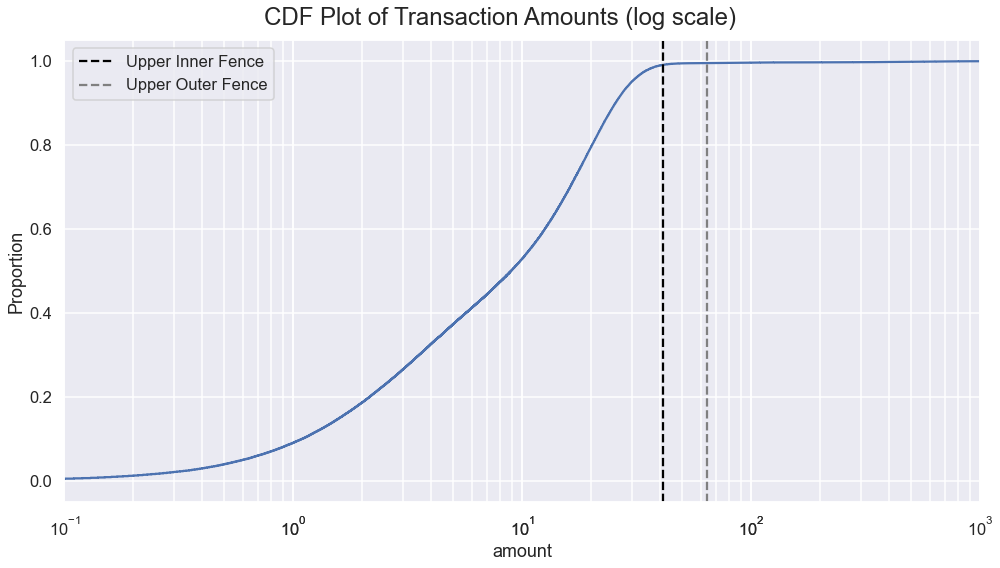

In [22]:
# Analyze transaction amounts for outliers

# Calculate median, quartiles and IQR
median_amount = transcript.amount.median()
q3_amount = transcript.amount.quantile([0.75])[0.75]
q1_amount = transcript.amount.quantile([0.25])[0.25]
iqr_amount = q3_amount - q1_amount

# Make ECDF plot of transaction amounts
f, ax = plt.subplots(figsize=(14,8))

# Seaborn's ECDF plot does not work with log_scale = True
# so have to set log scales manually
sns.ecdfplot(data=transcript, x='amount', log_scale=False, ax=ax)
ax.set(xscale='log')
ax.set(xlim=[0.1, 10], xticks=[10**x * y for x in range(-1, 3) for y in range(1,11)], ylim=[-.05, 1.05])

# Add outlier fences and label them
ax.axvline(q3_amount + iqr_amount * 1.5, color='black', ls='--', label='Upper Inner Fence')
ax.axvline(q3_amount + iqr_amount * 3, color='gray', ls='--', label='Upper Outer Fence')
ax.legend()

f.suptitle('CDF Plot of Transaction Amounts (log scale)', fontsize=24)
plt.tight_layout();

In [23]:
print("Outlier Fences:")
print("Lower Outer - Lower Inner - Upper Inner - Upper Outer")
print("{:10.2f}  {:10.2f}  {:12.2f}  {:12.2f}".format(q1_amount - 3*iqr_amount,
                                                  q1_amount - 1.5*iqr_amount,
                                                  q3_amount + 1.5*iqr_amount,
                                                  q3_amount + 3*iqr_amount))

Outlier Fences:
Lower Outer - Lower Inner - Upper Inner - Upper Outer
    -43.09      -20.15         41.00         63.94


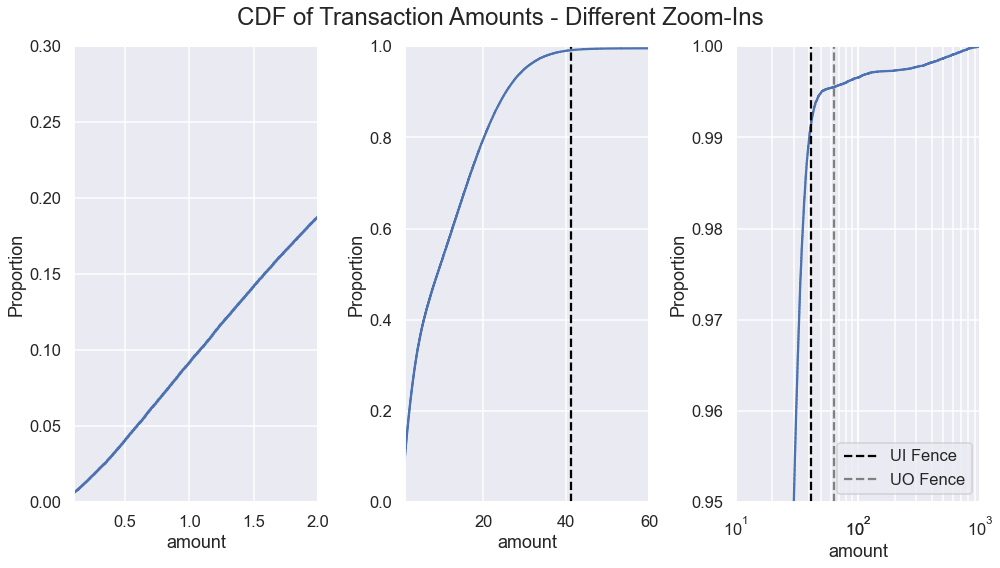

In [24]:
# Zoom the ECDF plot in to various parts of the curve to see statistical details

f, axs = plt.subplots(ncols=3, figsize=(14,8))
axs=axs.flatten()
sns.ecdfplot(data=transcript, x='amount', ax=axs[0])
axs[0].set(xlim=[0.1,2], ylim=[0,0.3])
sns.ecdfplot(data=transcript, x='amount', ax=axs[1])
axs[1].set(xlim=[1,60])
axs[1].axvline(q3_amount + iqr_amount * 1.5, color='black', ls='--', label='Upper Inner Fence')
axs[1].axvline(q3_amount + iqr_amount * 3, color='gray', ls='--', label='Upper Outer Fence')
sns.ecdfplot(data=transcript, x='amount', ax=axs[2])
axs[2].set(xlim=[50,1000], ylim=[0.95,1], xscale='log',
           xticks=[10**x * y for x in range(1, 3) for y in range(1,11)])
axs[2].axvline(q3_amount + iqr_amount * 1.5, color='black', ls='--', label='UI Fence')
axs[2].axvline(q3_amount + iqr_amount * 3, color='gray', ls='--', label='UO Fence')
axs[2].legend()
sns.ecdfplot(data=transcript, x='amount', ax=axs[2])
f.suptitle('CDF of Transaction Amounts - Different Zoom-Ins', fontsize=24)
plt.tight_layout();

In [25]:
# calculate cumulative revenue ordered by transaction volume and convert to fraction
amounts = transcript[transcript.event=='transaction'].sort_values('amount')
amounts['cumulative_amount'] = amounts.amount.cumsum()
amounts['frac_of_total'] = amounts.cumulative_amount / amounts.cumulative_amount.max()
amounts

,person,event,value,time,offer_id,amount,reward,cumulative_amount,frac_of_total
137918,76a37e94728b4b4abd31c6fda4f33855,transaction,{'amount': 0.05},366,NaN,0.05,NaN,0.05,2.816184e-08
228597,222ba48d2c664296a265201b7b7b6089,transaction,{'amount': 0.05},528,NaN,0.05,NaN,0.10,5.632369e-08
97587,84e28239d81b42188c27d974007dbfce,transaction,{'amount': 0.05},258,NaN,0.05,NaN,0.15,8.448553e-08
301683,047db31ef98140149f97667abee20860,transaction,{'amount': 0.05},690,NaN,0.05,NaN,0.20,1.126474e-07
292815,61347eea48ab406dbaeeced7b18c423d,transaction,{'amount': 0.05},654,NaN,0.05,NaN,0.25,1.408092e-07
...,...,...,...,...,...,...,...,...,...
302951,52959f19113e4241a8cb3bef486c6412,transaction,{'amount': 977.78},696,NaN,977.78,NaN,1771382.77,9.977081e-01
140346,dce784e26f294101999d000fad9089bb,transaction,{'amount': 989.34},372,NaN,989.34,NaN,1772372.11,9.982653e-01
42253,5ecaea5c8bf44ae4a65838d9d066c909,transaction,{'amount': 1001.85},102,NaN,1001.85,NaN,1773373.96,9.988296e-01
301790,454b00bdd77c4f588eb9f6cafd81dc5d,transaction,{'amount': 1015.73},690,NaN,1015.73,NaN,1774389.69,9.994017e-01


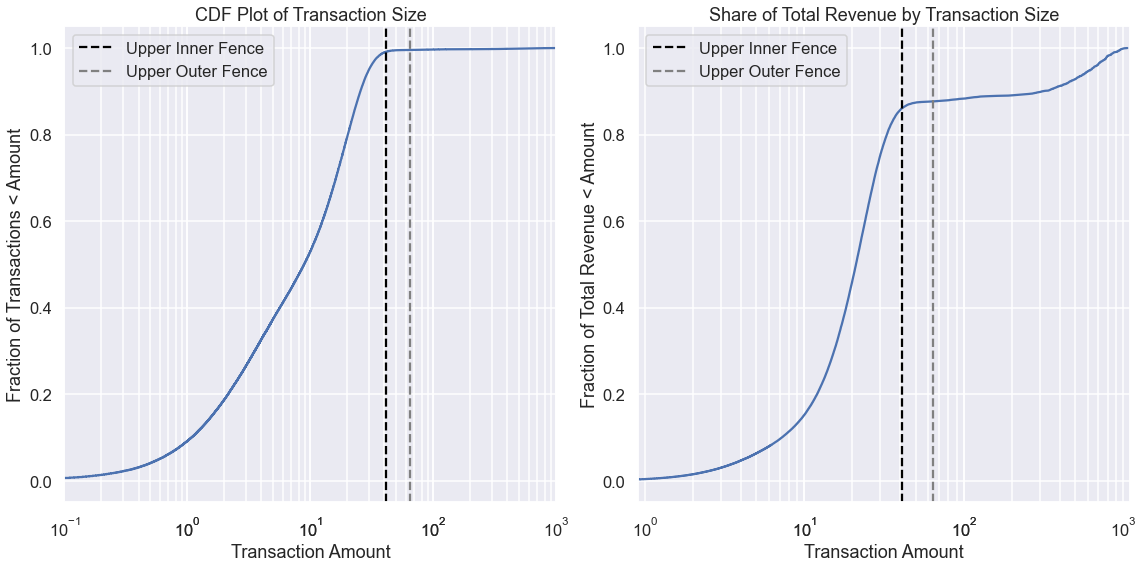

In [26]:
# ECDF plot of transaction size and cumulative share of revenue (as seen in blog post!)

f, axs = plt.subplots(ncols=2, figsize=(16,8))
axs = axs.flatten()

sns.ecdfplot(data=transcript, x='amount', log_scale=False, ax=axs[0])
axs[0].set(xscale='log')
axs[0].set(xlim=[0.1, 10], xticks=[10**x * y for x in range(-1, 3) for y in range(1,11)], ylim=[-.05, 1.05],
           ylabel='Fraction of Transactions < Amount', xlabel='Transaction Amount', title='CDF Plot of Transaction Size')
axs[0].axvline(q3_amount + iqr_amount * 1.5, color='black', ls='--', label='Upper Inner Fence')
axs[0].axvline(q3_amount + iqr_amount * 3, color='gray', ls='--', label='Upper Outer Fence')
axs[0].legend()

axs[1].plot(amounts.amount, amounts.frac_of_total)
axs[1].set(ylabel='Fraction of Total Revenue < Amount', xlabel='Transaction Amount', xscale='log',
      xlim=[0.9, 1100], xticks=[10**x * y for x in range(0, 3) for y in range(1,11)], ylim=[-.05, 1.05],
          title='Share of Total Revenue by Transaction Size')
axs[1].axvline(q3_amount + iqr_amount * 1.5, color='black', ls='--', label='Upper Inner Fence')
axs[1].axvline(q3_amount + iqr_amount * 3, color='gray', ls='--', label='Upper Outer Fence')
axs[1].legend()
plt.tight_layout()
plt.savefig('./images/Transaction_Size_Breakdown.png', dpi=600);

In [27]:
# look at how many transactions above certain values customers have
# 43: Inner Outlier Fence
# 53: Kink in transaction amount distribution
# 63: Upper Outlier Fence
n_transactions_over_41 = transcript[transcript.amount > 41].groupby('person').size().rename('n_transactions_over_41')
n_transactions_over_53 = transcript[transcript.amount > 53].groupby('person').size().rename('n_transactions_over_53')
n_transactions_over_63 = transcript[transcript.amount > 63].groupby('person').size().rename('n_transactions_over_63')

In [28]:
# Only 13 customers had 2 transactions over $53 during the test
# None had more than 2
print("Customer Count by number of Transactions over $53:")
n_transactions_over_53.value_counts()

Customer Count by number of Transactions over $53:


1    645
2     13
Name: n_transactions_over_53, dtype: int64

In [29]:
# To define what exactly an outlier transaction is, we will look at the user's 
# median transaction to maximum transaction ratio

# create "profile_extended" dataframe to augment while leaving base data unchanged
profile_extended = profile.copy()

# add median and maximum transaction amounts to the profiles dataset
profile_extended = pd.merge(profile_extended,
                            transcript.groupby(by='person')['amount'].median().rename('median_transaction'), 
         left_on='id', right_index=True, how='left')
profile_extended = pd.merge(profile_extended, transcript.groupby('person').amount.max().rename('max_transaction'),
                             left_on='id', right_index=True, how='left')
profile_extended['max_med_trans_ratio'] = profile_extended.max_transaction / profile_extended.median_transaction
profile_extended.head()

,gender,age,id,became_member_on,income,days_of_membership,anonymous,median_transaction,max_transaction,max_med_trans_ratio
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,1.89,5.21,2.756614
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,23.22,32.28,1.390181
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,1.89,4.09,2.164021
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,21.72,29.72,1.368324
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,1.09,3.50,3.211009


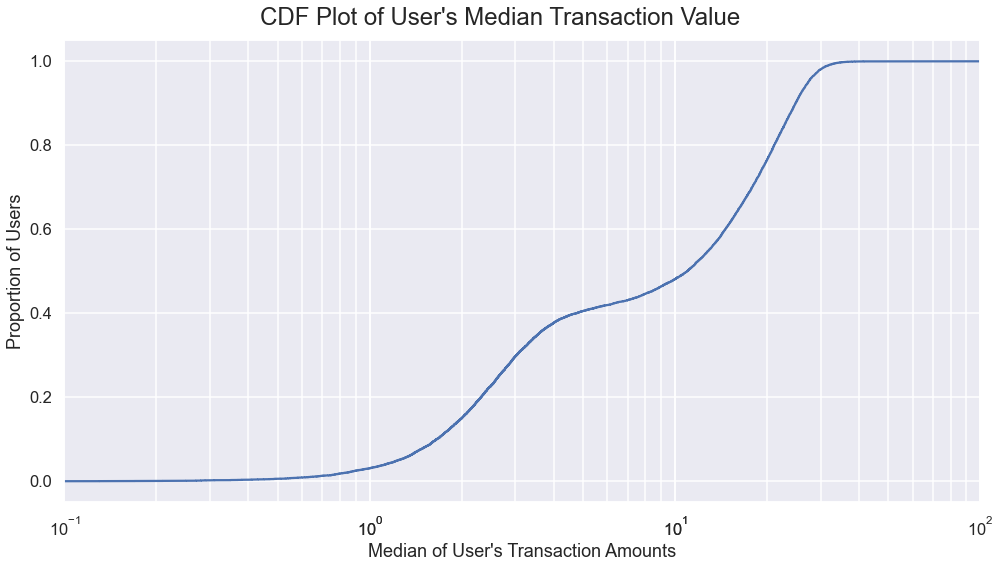

In [30]:
# CDF plot the median transactions by user

# The median of user transaction medians is, unsurprisingly, about $10 (identical to overall median)
# There is a clear subset of users who tend to spend less
f, ax = plt.subplots(figsize=(14,8))
g = sns.ecdfplot(data=profile_extended, x='median_transaction', log_scale=False, ax=ax)
ax.set(xscale='log')
ax.set(xlim=[0.1, 10], xticks=[10**x * y for x in range(-1, 2) for y in range(1,11)], ylim=[-.05, 1.05],
      ylabel='Proportion of Users', xlabel="Median of User's Transaction Amounts")
f.suptitle("CDF Plot of User's Median Transaction Value", fontsize=24)
plt.tight_layout();

In [31]:
# create bins for user's max and min transactions

# bins for max transaction are customized based on the distribution
profile_extended['max_transaction_binned'] = pd.cut(profile_extended.max_transaction,
                                                bins=[0, 20, 30, 41, 53, 63, 130, 2000],
                                            labels=['<20', '20-30', '30-41', '41-53', '53-63', '63-130', '>130'])

# bins for median transaction generalized using qcut
profile_extended['median_transaction_binned'] = pd.qcut(profile_extended.median_transaction, 8)

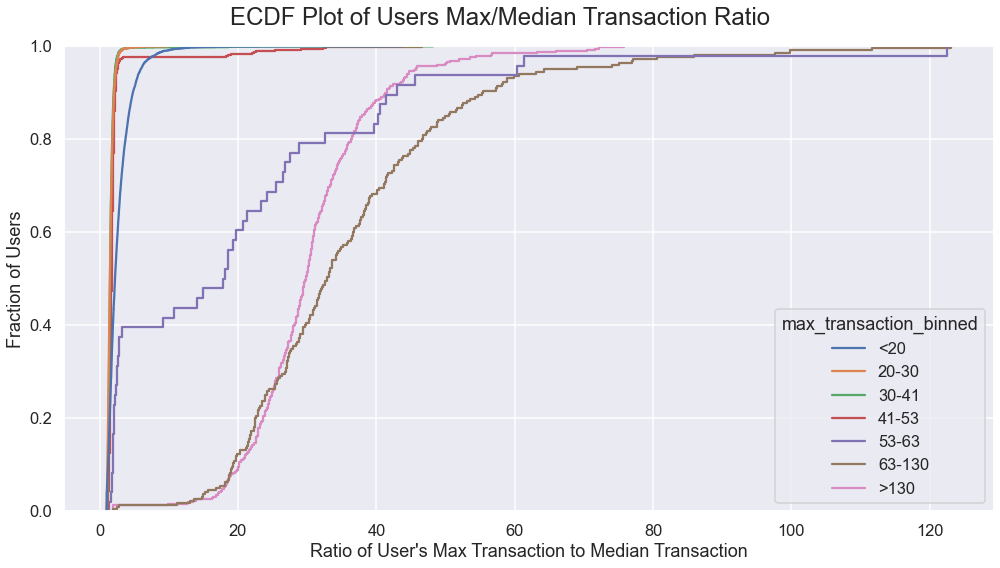

In [32]:
# plot max-median transaction ratio for different max transaction ranges

# major divergence between max and median shows up around $53 at a max/median ratio of 10
f, ax = plt.subplots(figsize=(14,8))
sns.ecdfplot(data=profile_extended, x='max_med_trans_ratio', hue='max_transaction_binned', ax=ax)
ax.set(xlabel="Ratio of User's Max Transaction to Median Transaction", ylabel='Fraction of Users')
f.suptitle('ECDF Plot of Users Max/Median Transaction Ratio', fontsize=24)
plt.tight_layout();

In [33]:
# Define outlier transactions as:
#  Transactions with Amount > 53
#           AND
#  Transaction Amount > 10 * User's Median Transaction Amount
#           OR
#  Transaction Amount > 100 (all transactions over this amount will be considered outliers)
transcript = pd.merge(transcript, profile_extended[['id', 'median_transaction']],
         left_on='person', right_on='id', how='left').drop(columns='id')
transcript['outlier'] = ((transcript.amount > 53) & (transcript.amount / transcript.median_transaction > 10) 
                         | (transcript.amount > 100))
transcript.head()

,person,event,value,time,offer_id,amount,reward,median_transaction,outlier
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,21.72,False
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,1.09,False
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,18.42,False
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,False
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0.12,False


In [34]:
# Barplot showing total revenue from outlier transactions
# Commented out because this is somewhat redundant with the CDF plot from earlier

#f, ax = plt.subplots(figsize=(14,8))
#sns.barplot(data=transcript, y='amount', x='outlier', estimator=sum, ci=None, ax=ax);

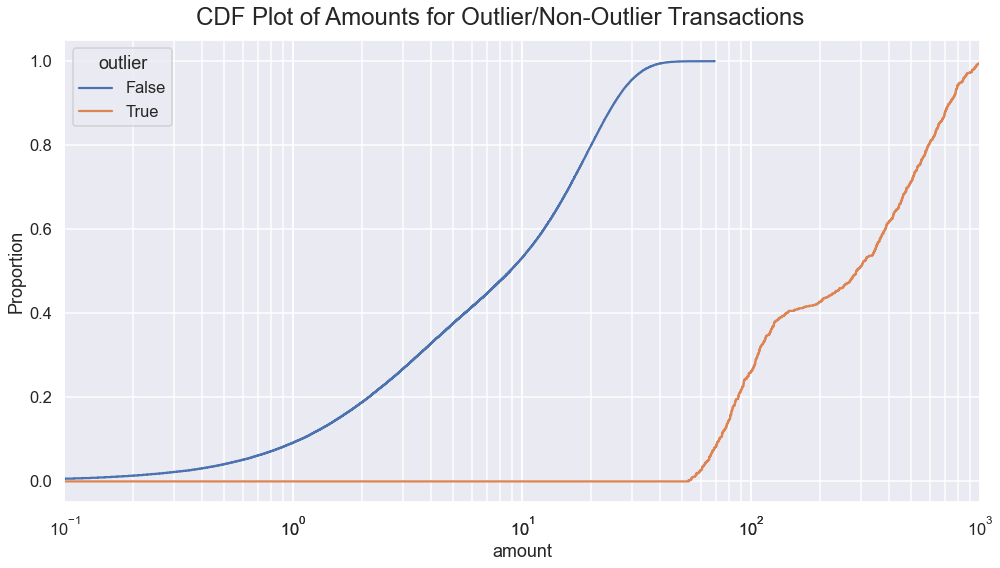

In [35]:
f, ax = plt.subplots(figsize=(14,8))
sns.ecdfplot(data=transcript, x='amount', hue='outlier', ax=ax)
ax.set(xscale='log')
ax.set(xlim=[0.1, 10], xticks=[10**x * y for x in range(-1, 3) for y in range(1,11)],
       ylim=[-.05, 1.05])
f.suptitle('CDF Plot of Amounts for Outlier/Non-Outlier Transactions', fontsize=24)
plt.tight_layout();

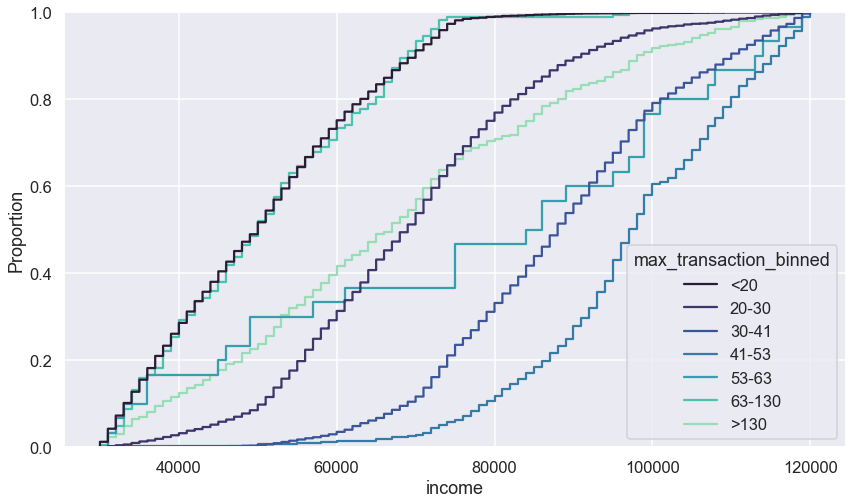

In [36]:
# Plot the income distribution separated out by max_transaction

# Income increases with maximum transaction size until we get to the outlier range
# then starts to decrease - this is likely because people making purchases for 
# businesses or schools have incomes across the distribution - some are secretaries, some
# are business owners

f, ax = plt.subplots(figsize=(14,8))
sns.ecdfplot(data=profile_extended, x='income', hue='max_transaction_binned', ax=ax,
             palette='mako');

In [37]:
# calculate maximum transaction excluding outliers

profile_extended = pd.merge(profile_extended,
                            (transcript[~transcript.outlier]
                                 .groupby('person')
                                 .amount
                                 .max()
                                 .rename('max_transaction_no_outliers')),
                             left_on='id', right_index=True, how='left')

# bin the max transaction excluding outliers
profile_extended['max_trans_no_out_binned'] = pd.cut(profile_extended.max_transaction_no_outliers,
                                                bins=[0, 20, 30, 41, 53, 2000],
                                                    labels=['<20', '20-30', '30-41', '41-53', '>53'])

# add median and maximum transaction amounts to the profiles dataset
profile_extended = pd.merge(profile_extended,
                            (transcript[~transcript.outlier]
                                 .groupby(by='person')
                                 .amount
                                 .median()
                                 .rename('median_transaction_no_outliers')), 
         left_on='id', right_index=True, how='left')

# bins for median transaction generalized using qcut
profile_extended['median_trans_no_out_binned'] = pd.qcut(profile_extended.median_transaction_no_outliers, 8)

profile_extended.head()

,gender,age,id,became_member_on,income,days_of_membership,anonymous,median_transaction,max_transaction,max_med_trans_ratio,max_transaction_binned,median_transaction_binned,max_transaction_no_outliers,max_trans_no_out_binned,median_transaction_no_outliers,median_trans_no_out_binned
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,1.89,5.21,2.756614,<20,"(1.83, 2.64]",5.21,<20,1.89,"(1.82, 2.63]"
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,23.22,32.28,1.390181,30-41,"(19.51, 23.819]",32.28,30-41,23.22,"(19.459, 23.75]"
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,1.89,4.09,2.164021,<20,"(1.83, 2.64]",4.09,<20,1.89,"(1.82, 2.63]"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,21.72,29.72,1.368324,20-30,"(19.51, 23.819]",29.72,20-30,21.72,"(19.459, 23.75]"
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,1.09,3.50,3.211009,<20,"(0.049, 1.83]",3.50,<20,1.09,"(0.049, 1.82]"


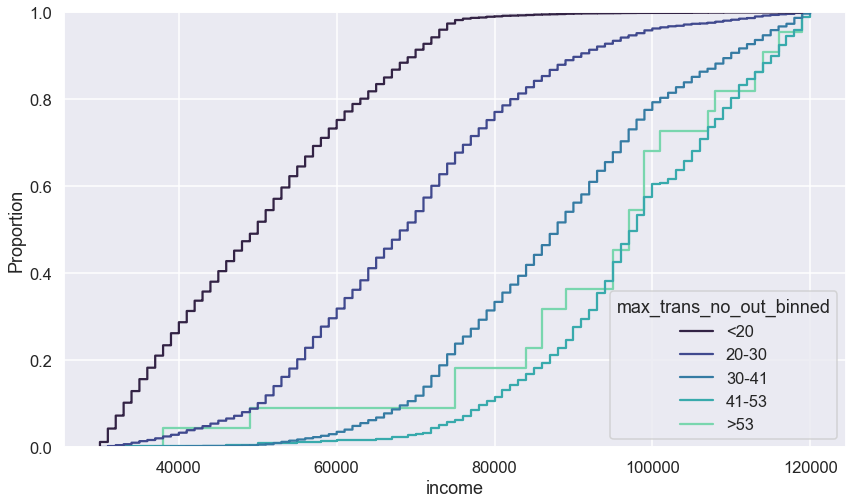

In [38]:
# After removing outliers, the distribution of income increases consistently with increasing max transaction size

f, ax = plt.subplots(figsize=(14,8))
sns.ecdfplot(data=profile_extended, x='income', hue='max_trans_no_out_binned', ax=ax,
             palette='mako');

In [39]:
# add a boolean for whether the customer made an outlier transaction
profile_extended = pd.merge(profile_extended, transcript.groupby('person').outlier.any().rename('has_outlier'),
         left_on='id', right_index=True, how='left')

## Processing the Transcript Data

To aid in the analysis of which users respond to which offers, a dataframe is needed which relates users to each individual offer event, along with information such as whether the offer was viewed and completed.  An example of such a structure would be:

|    | person                           | offer_id                         |   time_received | viewed   |   time_viewed | completed   |   time_completed |
|---:|:---------------------------------|:---------------------------------|----------------:|:---------|--------------:|:------------|-----------------:|
|  0 | 78afa995795e4d85b5d9ceeca43f5fef | 9b98b8c7a33c4b65b9aebfe6a799e6d9 |               0 | True     |             6 | True        |              132 |
|  1 | 78afa995795e4d85b5d9ceeca43f5fef | 5a8bc65990b245e5a138643cd4eb9837 |             168 | True     |           216 | False       |              nan |
|  2 | 78afa995795e4d85b5d9ceeca43f5fef | ae264e3637204a6fb9bb56bc8210ddfd |             408 | True     |           408 | True        |              510 |
|  3 | 78afa995795e4d85b5d9ceeca43f5fef | f19421c1d4aa40978ebb69ca19b0e20d |             504 | True     |           582 | True        |              510 |
|  4 | a03223e636434f42ac4c3df47e8bac43 | 0b1e1539f2cc45b7b9fa7c272da2e1d7 |               0 | True     |             6 | False       |              nan |
|  ... | ... | ... |               ... | ...     |             ... | ...       |              ... |

This is rendered _extremely_ complex by the lack of a unique identifier for each offer presentation event (offer presentation meaning a unique combination of user, offer, and time sent).  Since each offer can be sent multiple times, the transcript data cannot simply be grouped by person and offer and transformed in different ways to determine whether each specific offer has been viewed.  The duplication of offers causes these group-summarize-merge operations to be ambiguous - the grouping must be by person, offer, _and_ time sent.  Since time sent is not included with each view and completion event, this is not possible via groupby opereations.  Instead, the data must be processed line-by-line in order.  

There are a number of places where this problem also renders the data ambiguous.

### Offer Completion Ambiguity
During the test, offers were sent every 7 days.  Some offers have a duration of 10 days, and these longer offers can be sent back-to-back.  So a user can have 2 copies of the same offer active at the same time.  Consider the scenarios below:

![](./images/Back_to_back_illustration.png)

Scenarios 1, 2 and 3 are entirely ambiguous.  The offer completion could be considered applied to either of the two active offers.  It's possible that the future behavior could disambiguate the situation, as in scenario 4.  There the user later completes the second offer, allowing a firm conclusion that the first completion applied to the first offer.  But it's also possible that a third copy of the same offer could come in and complicate the situation again, as in scenario 5.  It's ambiguous, and a consistent logic has to be applied.

**To handle this scenario, any offer completion will be applied to the _oldest unexpired uncompleted_ offer of the same type.** This is consistent and makes sense for real-life app usage and offers.  Clearly the user would want the opportunity to complete the second offer, and as the offer was sent twice the marketing department would probably also like the user to have the opportunity to complete the second offer.

### Offer Viewing Ambiguity
Determining which duplicate of an offer a user has viewed is complicated further by the fact that an offer can be viewed after it has expired.  Consider the case of our good friend `d56cb6d6b61648fc9525678a207c38f1` (Deefty for short).  Deefty receives offer `9b98b8c7a33c4b65b9aebfe6a799e6d9` twice, which is a 7-day BOGO offer.

|    |   reward | channels                             |   difficulty |   duration | offer_type    | id                               |
|---:|---------:|:-------------------------------------|-------------:|-----------:|:--------------|:---------------------------------|
|  0 |       10 | ['email', 'mobile', 'social']        |           10 |          7 | bogo          | ae264e3637204a6fb9bb56bc8210ddfd |
|  1 |       10 | ['web', 'email', 'mobile', 'social'] |           10 |          5 | bogo          | 4d5c57ea9a6940dd891ad53e9dbe8da0 |
|  2 |        0 | ['web', 'email', 'mobile']           |            0 |          4 | informational | 3f207df678b143eea3cee63160fa8bed |
|**3**|    **5** | **['web', 'email', 'mobile']**       |        **5** |      **7** | **bogo**      | **9b98b8c7a33c4b65b9aebfe6a799e6d9** |
|  4 |        5 | ['web', 'email']                     |           20 |         10 | discount      | 0b1e1539f2cc45b7b9fa7c272da2e1d7 |

In Deefty's transcript, they receive the offer twice with a gap in between, then view one of the offers.

|        | person                           | event          | value                                            |   time |
|-------:|:---------------------------------|:---------------|:-------------------------------------------------|-------:|
|   8736 | d56cb6d6b61648fc9525678a207c38f1 | offer received | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |      0 |
|  17323 | d56cb6d6b61648fc9525678a207c38f1 | offer viewed   | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |      6 |
|  17324 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 0.35000000000000003}                  |      6 |
|  37810 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 7.46}                                 |     78 |
|  39124 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 1.58}                                 |     84 |
|**61923**|**d56cb6d6b61648fc9525678a207c38f1**|**offer received**|**{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}**| **168** |
| 119567 | d56cb6d6b61648fc9525678a207c38f1 | offer received | {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'} |    336 |
| 126056 | d56cb6d6b61648fc9525678a207c38f1 | offer viewed   | {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'} |    336 |
| 159376 | d56cb6d6b61648fc9525678a207c38f1 | offer received | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |    408 |
| 170117 | d56cb6d6b61648fc9525678a207c38f1 | offer viewed   | {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'} |    414 |
| 170118 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 1.6099999999999999}                   |    414 |
|**210312**|**d56cb6d6b61648fc9525678a207c38f1**|**offer received**|**{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}**|  **504**|
| 289170 | d56cb6d6b61648fc9525678a207c38f1 | transaction    | {'amount': 2.85}                                 |    642 |
|**305072**|**d56cb6d6b61648fc9525678a207c38f1**|**offer viewed** |**{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}**|  **708**|

The expiry time of the second offer is `504 + 7 * 24 = 672`, meaning that both of the offers are expired when Deefty views one of the two offers at `time=708`.  Intuition might apply LIFO logic and say he viewed the most recent one - but given that offers can be viewed after expiry FIFO logic could also be applied (as it was in the offer completion).  Again, the situation is ambiguous and a consistent logic must be applied.  The stakes are slightly higher here, since a user may later complete the offer.  If the view was applied to the wrong version of the offer, this could erroneously show that the user completed the offer without viewing it.

Consider now examples 6 and 7: in both it's clear that the customer viewed the second instance of the offer.  But which one did they view?  It's impossible to say.  Again, a simple and consistent approach is needed.

**To handle ambiguous view data, offer views will be applied:**
1. To the _oldest unexpired unviewed_ offer
-- if there are no active unviewed offers --  

2. To the _oldest expired unviewed_ offer

### Recommendation
These types of ambiguities can have a significant impact on the results.  To improve the data integrity, the data enginers / app developers should be requested to:
1. Establish an ID which uniquely identifies each offer presentation (offer presentation meaning a unique comination of person / offer / time_received)
2. Reference offer views and offer completions to the appropriate offer presentation ID

Depending on the workings of the systems, it is possible that there is a consistent logic which is applied in these ambiguous situations.  In a business situation (where conversations with the app development and loyalty program teams are possible) there is also the possiblity of mapping out the logic flow applied by the real systems in these ambiguous situations and then duplicating that logic in the data processing.  However, the unique ID route is preferred for performance reasons (querying the dataset is faster than iterating through it line by line) and because future system changes could alter the logic flow and compromise data integity again.

In [40]:
# from this transcript we know it is possible to complete two offers with the same
# transaction - how common is this?

transcript_disp = transcript[transcript.person=='3526938fb466470190a504a751ec07b0'].copy()
transcript_disp['person'] = transcript_disp.person.str.slice(stop=9) + " ... (Owen)"
transcript_disp[['person', 'event', 'value', 'time', 'reward']]

,person,event,value,time,reward
7859,3526938fb ... (Owen),offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN
55912,3526938fb ... (Owen),offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},168,NaN
113527,3526938fb ... (Owen),offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336,NaN
158510,3526938fb ... (Owen),offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},408,NaN
184061,3526938fb ... (Owen),transaction,{'amount': 12.68},444,NaN
209430,3526938fb ... (Owen),offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504,NaN
220614,3526938fb ... (Owen),transaction,{'amount': 22.39},510,NaN
220615,3526938fb ... (Owen),offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,510,5.0
220616,3526938fb ... (Owen),offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,510,5.0
220617,3526938fb ... (Owen),offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,510,5.0


In [41]:
# group all offer completions at by time and put them in a list
simul_compl = (transcript[transcript.event=='offer completed']
                                  .groupby(by=['person', 'time'])['offer_id'].unique()).reset_index().copy()
# look for simultaneous completions by looking only at lists long than 1 offer
simul_compl = simul_compl[simul_compl.offer_id.str.len() > 1]
simul_compl.head()

,person,time,offer_id
4,0011e0d4e6b944f998e987f904e8c1e5,576,"[0b1e1539f2cc45b7b9fa7c272da2e1d7, 9b98b8c7a33..."
6,0020c2b971eb4e9188eac86d93036a77,510,"[fafdcd668e3743c1bb461111dcafc2a4, 4d5c57ea9a6..."
45,00ae03011f9f49b8a4b3e6d416678b0b,618,"[ae264e3637204a6fb9bb56bc8210ddfd, 2298d6c36e9..."
69,00c2f812f4604c8893152a5c6572030e,582,"[2906b810c7d4411798c6938adc9daaa5, 4d5c57ea9a6..."
76,00cf1bbec83f4a658f8994e556db4633,564,"[fafdcd668e3743c1bb461111dcafc2a4, 2906b810c7d..."


In [42]:
# now we need to turn the offer id list into new rows in the dataframe
# and also need the nicknames to properly understand it

                        # explode function turns list into rows
simul_compl = pd.merge(simul_compl.explode('offer_id'),
                       # then join in the nickname
                       portfolio[['id', 'nickname']],
                       left_on='offer_id', right_on='id', how='left').drop(columns='id')
simul_compl.head()

,person,time,offer_id,nickname
0,0011e0d4e6b944f998e987f904e8c1e5,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,disc-20/5/10
1,0011e0d4e6b944f998e987f904e8c1e5,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5/5/7
2,0020c2b971eb4e9188eac86d93036a77,510,fafdcd668e3743c1bb461111dcafc2a4,disc-10/2/10
3,0020c2b971eb4e9188eac86d93036a77,510,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10/10/5
4,00ae03011f9f49b8a4b3e6d416678b0b,618,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10/10/7


In [43]:
# now want to understand the number of completions as a fraction of total completions
                    # back to the transcript
sim_compl_as_frac = (transcript[transcript.event=='offer completed']
            # get the number of completions by offer
         .groupby('offer_id')
         .size()
            # turn it back into a dataframe
         .to_frame('total_completions')
            # bring in the nickname and set index as offer id
         .join(portfolio[['id', 'nickname']].set_index('id'), how='left')
            # bring in the number of simultaneous completions
         .join(simul_compl.groupby('offer_id').size().rename('simultaneous_completions'), how='left'))

# calculate fraction by division
sim_compl_as_frac['frac_of_compl_simultaneous'] = \
                    sim_compl_as_frac.simultaneous_completions / sim_compl_as_frac.total_completions
sim_compl_as_frac.head()

,total_completions,nickname,simultaneous_completions,frac_of_compl_simultaneous
offer_id,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,3420,disc-20/5/10,774,0.226316
2298d6c36e964ae4a3e7e9706d1fb8c2,5156,disc-7/3/7,634,0.122964
2906b810c7d4411798c6938adc9daaa5,4017,disc-10/2/7,666,0.165795
4d5c57ea9a6940dd891ad53e9dbe8da0,3331,bogo-10/10/5,469,0.140799
9b98b8c7a33c4b65b9aebfe6a799e6d9,4354,bogo-5/5/7,676,0.155260


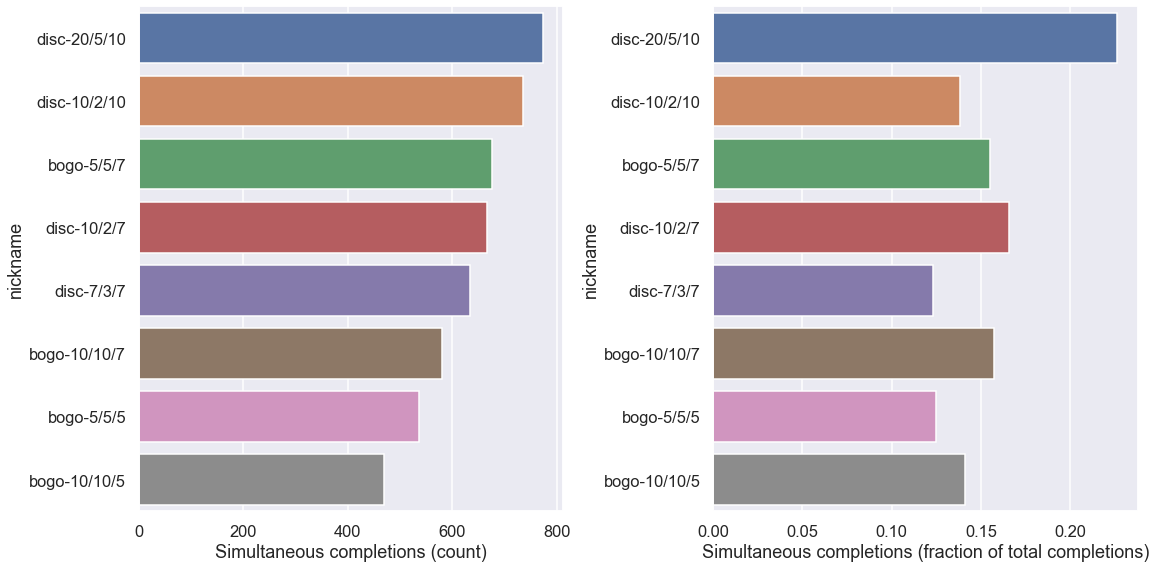

In [44]:
# Chart simultaneous completions
f, axs = plt.subplots(ncols=2, figsize=(16,8))
axs=axs.flatten()
# raw number using countplot
sns.countplot(data=simul_compl, y='nickname', ax=axs[0], 
              order=simul_compl.groupby('nickname').size().sort_values(ascending=False).index)
axs[0].set(xlabel='Simultaneous completions (count)')

# fraction using barplot
sns.barplot(data=sim_compl_as_frac, y='nickname', x='frac_of_compl_simultaneous', ax=axs[1],
           order=simul_compl.groupby('nickname').size().sort_values(ascending=False).index)
axs[1].set(xlabel='Simultaneous completions (fraction of total completions)')
plt.tight_layout()
plt.savefig('./images/Simultaneous_Completions.png', dpi=600);

In [45]:
# What about views?  Were there any cases where a customer viewed two 
# instances of the same offer at the same time?

# Spoiler alert - that's a no.
simul_views = transcript[transcript.event == 'offer viewed'].groupby(by=['person', 'offer_id','time']).size()
print("Maximum simultaneous views of the same offer:", simul_views.max())
simul_views_any = transcript[transcript.event == 'offer viewed'].groupby(by=['person','time']).size()
print("Maximum simultaneous views of any offer:", simul_views_any.max())

Maximum simultaneous views of the same offer: 1
Maximum simultaneous views of any offer: 1


## Processing Transcript for Offer View/Complete Data

With the complexities on the table, time to process the transcript.

In [46]:
# initialize results
offers_dict = {'person': [], 'offer_id': [], 'time_received': [],
              'viewed': [], 'time_viewed': [], 'completed': [], 'time_completed': []}

# iterate through people in the transcripts dataframe
for person in progressbar.progressbar(transcript.person.unique()):
    # pull this person's transcript and sort it by time
    person_transcript = transcript[transcript.person == person].copy().sort_index()
    # set up a dict of offers received by this person
    offers_tmp = {}
    # iterate through entries in the transcript
    for _, tmp in person_transcript.iterrows():
        # entry == offer received
        if tmp.event == 'offer received':
            # add to list of offers
            base_dict = {'viewed': False, 'time_viewed': np.NaN, 
                                    'completed': False, 'time_completed': np.NaN}
            # Need separate cases here:
            #  - Establish the dictionary if this is the first instance of the offer
            #  - Not overwrite the dictionary if this offer has already been given to this user
            if tmp.offer_id in offers_tmp.keys():
                offers_tmp[tmp.offer_id][tmp.time] = base_dict
            else:
                offers_tmp[tmp.offer_id] = {tmp.time: base_dict}
            
            # calculate expiry time and add to dict
            duration_h = portfolio[portfolio.id == tmp.offer_id].reset_index().duration[0] * 24
            offers_tmp[tmp.offer_id][tmp.time]['expiry_time'] = tmp.time + duration_h
            
        # entry == offer viewed
        if tmp.event == 'offer viewed':
            # go through all times this offer has been sent
            view_applied = False
            for previous_time in sorted(list(offers_tmp[tmp.offer_id].keys())):
                # if this iteration of the offer has not expired and has not been viewed
                if (offers_tmp[tmp.offer_id][previous_time]['expiry_time'] >= tmp.time and not 
                    offers_tmp[tmp.offer_id][previous_time]['viewed']):
                    # set viewed to true, set viewed time to now and break out of this loop
                    offers_tmp[tmp.offer_id][previous_time]['viewed'] = True
                    offers_tmp[tmp.offer_id][previous_time]['time_viewed'] = tmp.time
                    view_applied = True
                    break
            
            # if an unexpired unviewed offer was not found
            if not view_applied:
                # iterate back through the list of times this offer has been sent
                for previous_time in sorted(list(offers_tmp[tmp.offer_id].keys())):
                    # this time ignore expiry, only look for unviewed versions
                    if not offers_tmp[tmp.offer_id][previous_time]['viewed']:
                        # when the oldest unviewed offer is found, set variables and break out
                        offers_tmp[tmp.offer_id][previous_time]['viewed'] = True
                        offers_tmp[tmp.offer_id][previous_time]['time_viewed'] = tmp.time
                        break
        
        # entry == offer completed
        if tmp.event == 'offer completed':
            # go through all the times this offer has been sent
            for previous_time in sorted(list(offers_tmp[tmp.offer_id].keys())):
                # if this iteration of the offer has not expired and has not been completed
                if (offers_tmp[tmp.offer_id][previous_time]['expiry_time'] >= tmp.time and not 
                    offers_tmp[tmp.offer_id][previous_time]['completed']):
                    # set completed to true, set viewed time to now and break out of this loop
                    offers_tmp[tmp.offer_id][previous_time]['completed'] = True
                    offers_tmp[tmp.offer_id][previous_time]['time_completed'] = tmp.time
                    break
    
    # unroll this person's offers into the results dict
    for offer in offers_tmp.keys():
        for time_received in offers_tmp[offer].keys():
            offers_dict['person'].append(person)
            offers_dict['offer_id'].append(offer)
            offers_dict['time_received'].append(time_received)
            offers_dict['viewed'].append(offers_tmp[offer][time_received]['viewed'])
            offers_dict['time_viewed'].append(offers_tmp[offer][time_received]['time_viewed'])
            offers_dict['completed'].append(offers_tmp[offer][time_received]['completed'])
            offers_dict['time_completed'].append(offers_tmp[offer][time_received]['time_completed'])

100% (17000 of 17000) |##################| Elapsed Time: 0:07:15 Time:  0:07:15


In [47]:
offers_df = pd.DataFrame.from_dict(offers_dict)
del offers_dict
offers_df.head()

,person,offer_id,time_received,viewed,time_viewed,completed,time_completed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,6.0,True,132.0
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,True,216.0,False,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,True,408.0,True,510.0
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,True,582.0,True,510.0
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,True,6.0,False,NaN


In [48]:
# Do some checks to confirm the processing was done properly

# Confirm correct number of total offers
assert(offers_df.shape[0] == transcript[transcript.event=='offer received'].shape[0])
# Confirm correct number of total views
assert(offers_df.viewed.sum() == transcript[transcript.event=='offer viewed'].shape[0])
# Confirm correct number of total completions
assert(offers_df.completed.sum() == transcript[transcript.event=='offer completed'].shape[0])

# Confirm the same 3 things for 5 random users
for user in np.random.default_rng().choice(profile.id, 5):
    user_transcript = transcript[transcript.person==user]
    assert(offers_df[offers_df.person==user].shape[0] == 
           user_transcript[user_transcript.event=='offer received'].shape[0])
    assert(offers_df[offers_df.person==user].viewed.sum() == 
           user_transcript[user_transcript.event=='offer viewed'].shape[0])
    assert(offers_df[offers_df.person==user].completed.sum() == 
           user_transcript[user_transcript.event=='offer completed'].shape[0])

# Combining the Transcript and Profile datasets (breakdown by user)

In [49]:
# Come back to the portfolio dataframe to understand the test and the customer base a bit better
# Extract total of non-outlier transactions and total transaction value from transcript
transactions_info = (transcript[(transcript.event=='transaction') & (~transcript.outlier)]
                                        .groupby('person')
                                        .agg(n_transactions=pd.NamedAgg(column='person', aggfunc=len),
                                             total_amount=pd.NamedAgg(column='amount', aggfunc=sum)))

# Extract data about offer sending, viewing and completion from the offers dataframe

# Summarize offer info by person
offers_sent = (offers_df.groupby(by=['person', 'offer_id'])['time_received'].nunique()
               .rename('times_received').reset_index()
               .groupby('person')['times_received'].sum().rename('n_offers'))
offers_viewed = offers_df.groupby(by='person').viewed.sum().rename('n_offers_viewed')
offers_completed = offers_df.groupby(by='person').completed.sum().rename('n_offers_completed')

# Calculate number of times offers were completed without being viewed and summarize by person
offers_df['completed_not_viewed'] = (((offers_df.completed) & ~(offers_df.viewed)) |
                                     (offers_df.time_completed < offers_df.time_viewed))
offers_completed_not_viewed = (offers_df.groupby(by='person')
                               .completed_not_viewed
                               .sum()
                               .rename('n_offers_completed_not_viewed'))

In [50]:
# Merge the generated datasets into the extended profile
for extension in [transactions_info, offers_sent, offers_viewed, offers_completed, offers_completed_not_viewed]:
    profile_extended = pd.merge(profile_extended, extension, left_on='id', right_index=True, how='left')
    del extension

# Any NaNs in this new data indicate that the person had zero (zero transactions, zero offers viewed, etc)
# Need to populate this in the dataframe
for column in ['n_transactions', 'total_amount', 'n_offers',
                         'n_offers_viewed', 'n_offers_completed', 'n_offers_completed_not_viewed']:
    profile_extended[column] = profile_extended[column].fillna(0)

# NaNs occur in this calculation because of div0 errors from six users who got no offers
# Fill those with 0
profile_extended['frac_viewed'] = (profile_extended.n_offers_viewed / profile_extended.n_offers).fillna(0)
profile_extended['frac_completed'] = (profile_extended.n_offers_completed / profile_extended.n_offers).fillna(0)
profile_extended['frac_completed_unviewed'] = \
                    (profile_extended.n_offers_completed_not_viewed / profile_extended.n_offers).fillna(0)
profile_extended.head()

,gender,age,id,became_member_on,income,days_of_membership,anonymous,median_transaction,max_transaction,max_med_trans_ratio,...,has_outlier,n_transactions,total_amount,n_offers,n_offers_viewed,n_offers_completed,n_offers_completed_not_viewed,frac_viewed,frac_completed,frac_completed_unviewed
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,1.89,5.21,2.756614,...,False,9.0,20.40,5.0,5.0,2.0,0.0,1.0,0.40,0.00
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,23.22,32.28,1.390181,...,False,3.0,77.01,2.0,0.0,1.0,1.0,0.0,0.50,0.50
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,1.89,4.09,2.164021,...,False,6.0,14.30,2.0,2.0,0.0,0.0,1.0,0.00,0.00
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,21.72,29.72,1.368324,...,False,7.0,159.27,4.0,4.0,3.0,1.0,1.0,0.75,0.25
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,1.09,3.50,3.211009,...,False,3.0,4.65,5.0,3.0,0.0,0.0,0.6,0.00,0.00


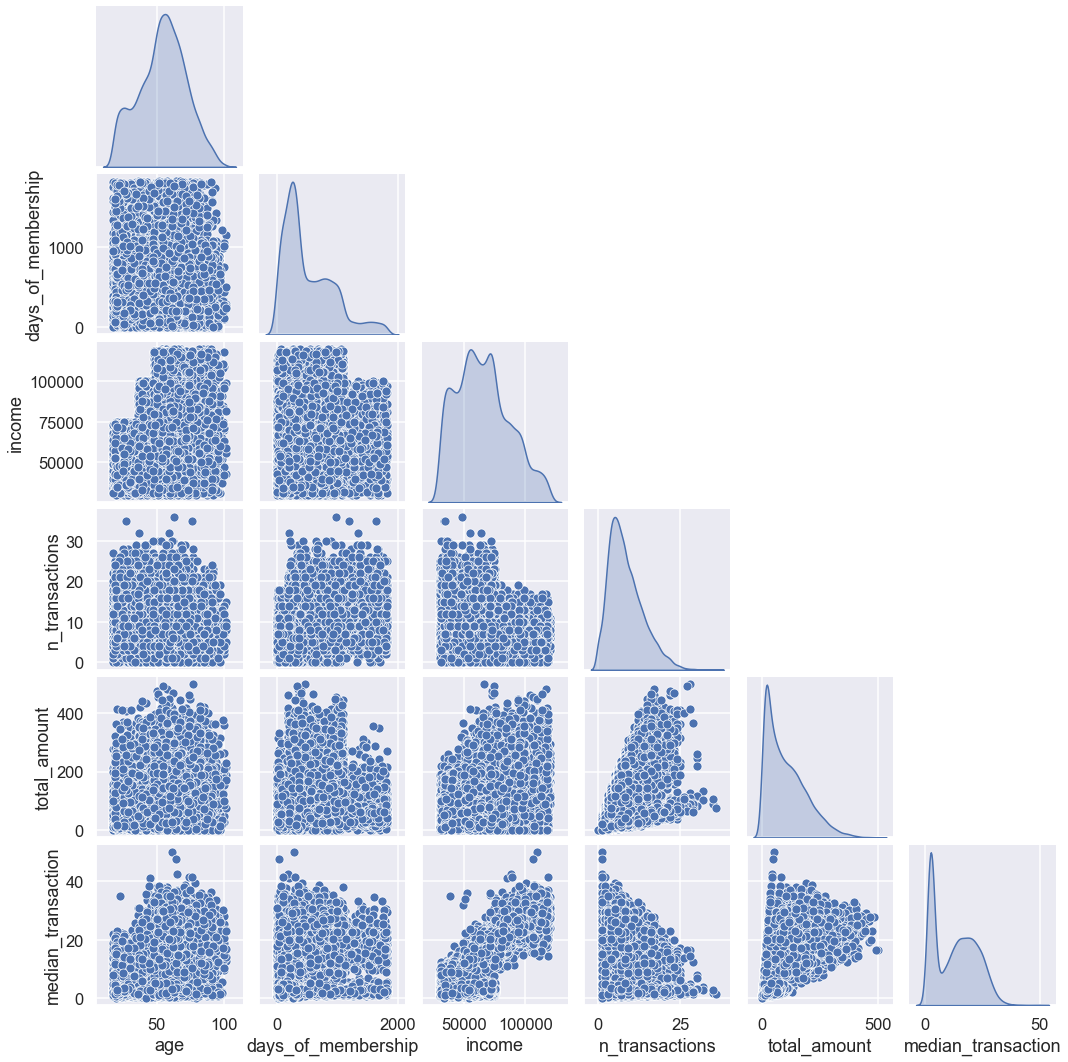

In [51]:
# Examine pairwise relationships in the extended data

# Relationship between median transaction and income, median transaction and total amount
# total amount and n_transactions

# There are also a number of unnatural-looking "corner edges" in the dataset, likely due to the setup
# of the simulation and the subgroups of users who were defined in it. (ex: income vs age)
sns.pairplot(profile_extended[~profile_extended.anonymous].loc[:,
                                  ['gender','age','days_of_membership','income', 'n_transactions', 'total_amount',
                                  'median_transaction_no_outliers']].rename(
                                      columns={'median_transaction_no_outliers': 'median_transaction'})
             , corner=True, diag_kind='kde');

In [52]:
## Define plotting routine as a function to reduce repetition
def plot_transcript_vs_categorical(data, category, title="", all_legend=True, hue_order=None):
    """
    Function to plot a seaborn ecdfplot of transaction data, split by a specific categorical variable.
    
    INPUT:
    data: (dataframe) the dataframe to plot
    category: (string) the category to separate by color
    title: (string) the title to put above the plot
    all_legend: (boolean) whether to put legends on all plots.  if false, place only on the last one
    hue_order: (list-like) passed to sns.ecdfplot to control order of the categorical levels
    
    RETURNS:
    none - outputs a a group of plots to the console
    """
    f, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10))
    axs = axs.flatten()
    
    if all_legend:
        legends = lambda i, axs: True if i>0 else True
    else:
        legends = lambda i, axs: True if i+1==len(axs) else False
    
    for i, column in enumerate(['n_transactions', 'total_amount', 'n_offers',
                         'frac_viewed', 'frac_completed', 'frac_completed_unviewed']):
        sns.ecdfplot(data=data, x=column, hue=category, ax=axs[i], legend=legends(i, axs), hue_order=hue_order)
        axs[i].set(ylim=[-0.05, 1.05])
    
    f.suptitle(title, fontsize=24)
    plt.tight_layout()

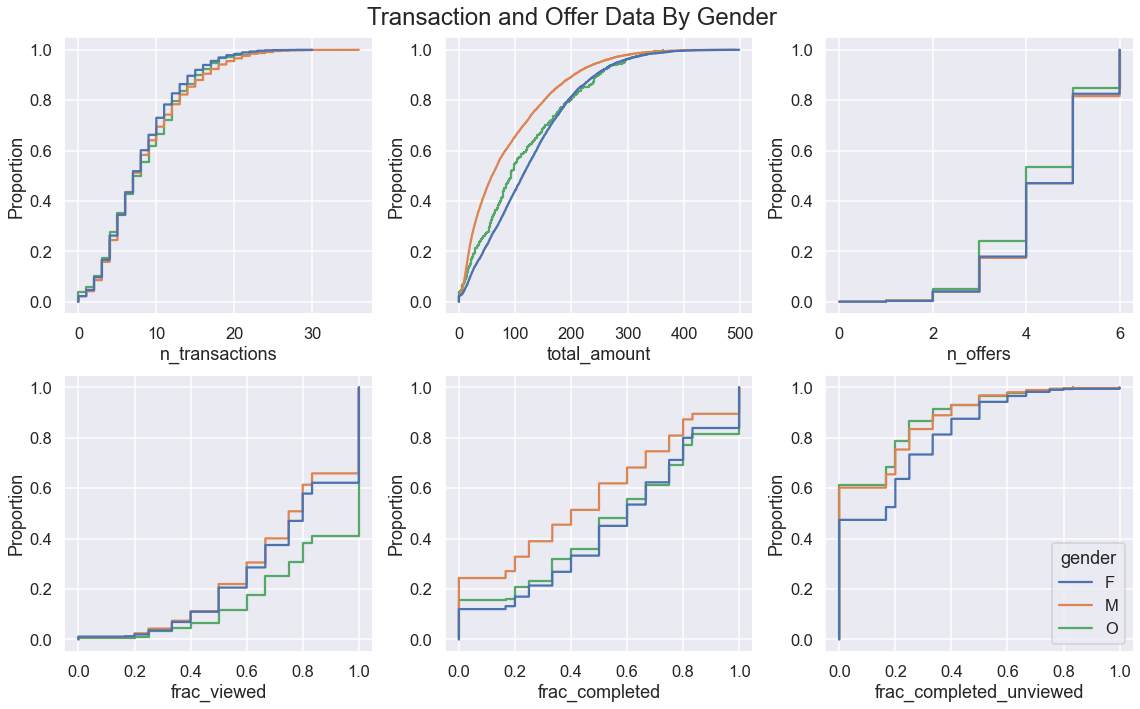

In [53]:
plot_transcript_vs_categorical(profile_extended, 'gender', "Transaction and Offer Data By Gender", False)

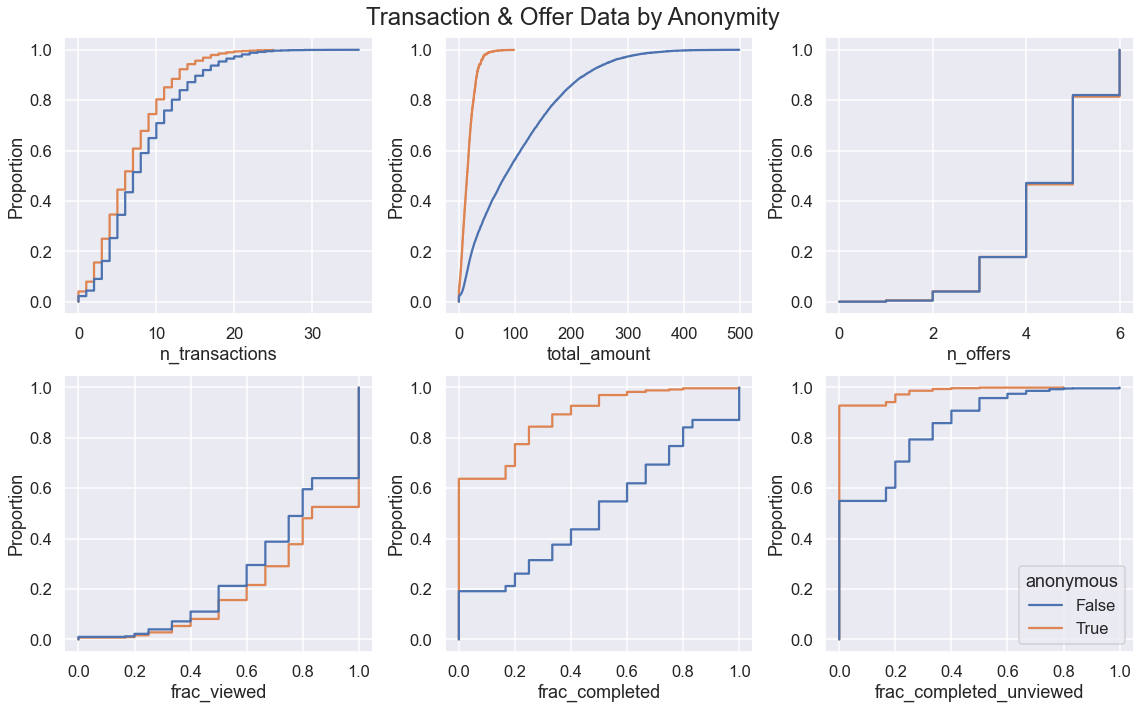

In [54]:
plot_transcript_vs_categorical(profile_extended, 'anonymous', "Transaction & Offer Data by Anonymity", False)
plt.savefig('./images/Transaction_Breakdown_Anonymous.png', dpi=600)

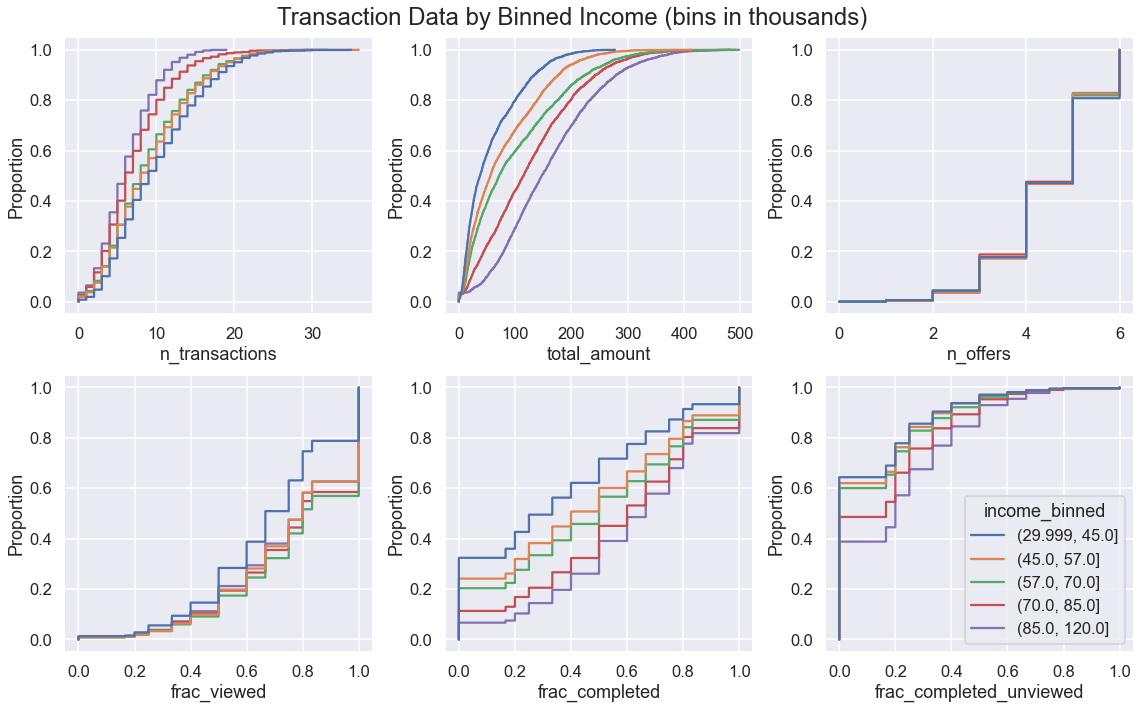

In [55]:
profile_extended.loc[~profile_extended.anonymous,'income_binned'] = \
                pd.qcut(profile_extended[~profile_extended.anonymous].income / 1000, 5)

order_income = profile_extended.income_binned.dropna().sort_values().unique()

plot_transcript_vs_categorical(profile_extended, 'income_binned', 
                               "Transaction Data by Binned Income (bins in thousands)", False, order_income)

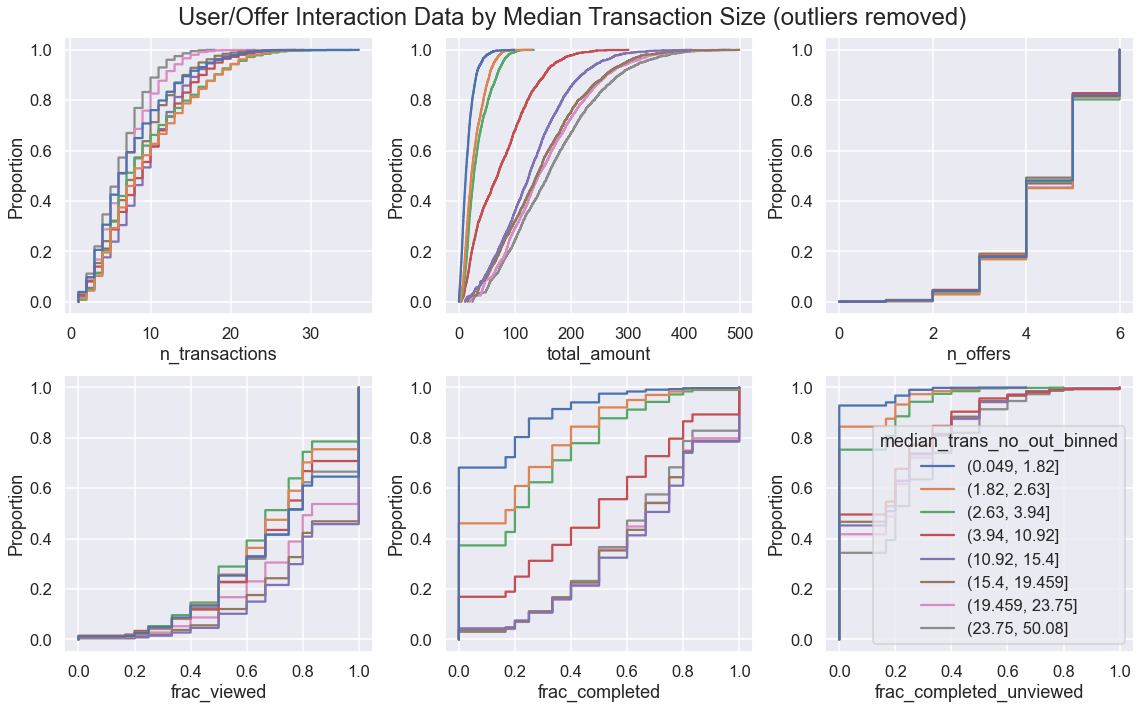

In [56]:
plot_transcript_vs_categorical(profile_extended, 'median_trans_no_out_binned',
                        "User/Offer Interaction Data by Median Transaction Size (outliers removed)", False)

In [57]:
profile_extended.loc[~profile_extended.anonymous,'age_binned'] = \
                pd.qcut(profile_extended[~profile_extended.anonymous].age, 8)

order_age = profile_extended.age_binned.dropna().sort_values().unique()

# Not plotted to streamline notebook - conclusions are in the remarks

# plot_transcript_vs_categorical(profile_extended, 'age_binned', "Transaction Data by Binned Age", False, order_age)

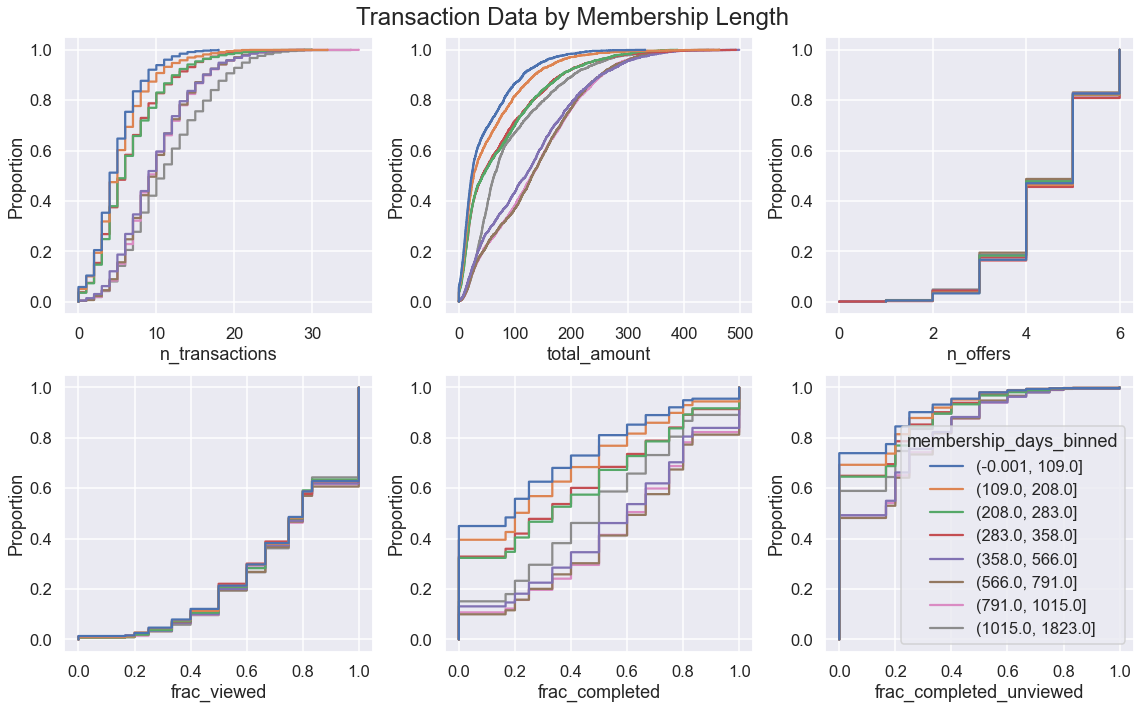

In [58]:
profile_extended['membership_days_binned'] = \
                pd.qcut(profile_extended.days_of_membership, 8)

order_membership = profile_extended.membership_days_binned.dropna().sort_values().unique()

plot_transcript_vs_categorical(profile_extended, 'membership_days_binned',
                               "Transaction Data by Membership Length", False, order_membership)

In [59]:
# Anonymous users show the same characteristics as users with a profile

#plot_transcript_vs_categorical(profile_extended[profile_extended.anonymous], 'membership_days_binned',
#                        "Transaction Data by Membership Length, anonymous users only", False, order_membership)

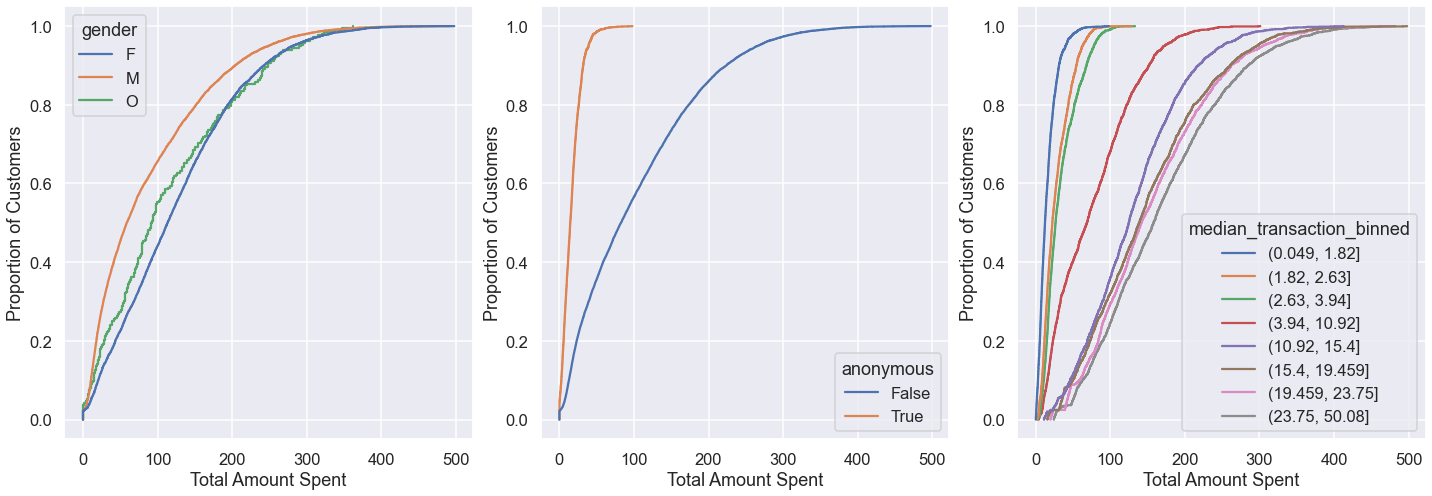

In [60]:
f, axs = plt.subplots(ncols=3, figsize=(20,7))
axs=axs.flatten()

sns.ecdfplot(data=profile_extended, x='total_amount', hue='gender', ax=axs[0])
sns.ecdfplot(data=profile_extended.rename(columns={'median_transaction_binned': '_',
                                                   'median_trans_no_out_binned': 'median_transaction_binned'}),
                                         x='total_amount', hue='median_transaction_binned', ax=axs[2])
sns.ecdfplot(data=profile_extended, x='total_amount', hue='anonymous', ax=axs[1])
axs[0].set(ylim=[-.05, 1.05], xlabel='Total Amount Spent', ylabel='Proportion of Customers')
axs[1].set(ylim=[-.05, 1.05], xlabel='Total Amount Spent', ylabel='Proportion of Customers')
axs[2].set(ylim=[-.05, 1.05], xlabel='Total Amount Spent', ylabel='Proportion of Customers')
plt.tight_layout();
plt.savefig('./images/KDEPlot_Separation_Comparison.png', dpi=600)

## Observations from exploratory data analysis on transaction and profile datasets

Note that all statements are based on the exploratory analysis only, and not a proper hypothesis test.  It is likely that not all of the observations below are statistically significant, and not all will be explored in this work.

#### Pairwise relationships on continuous variables

- There are logical relationships between median transaction:income, as well as median transaction:total amount and total amount:n_transactions


- There are also a number of unnatural-looking "corner edges" in the dataset, likely due to the setup of the simulation and the subgroups of users who were defined in it.  This is most prominent in the chart of income vs age.

#### Gender

- Women have slightly fewer total transactions than Men or Other.
- Women and Other spend slightly more in total than Men.
- People with Gender: Other are less likely to view offers than Men or Women.
- Men are less likely to complete offers than Women or Other.
- As a consequence of the above 2, Other are more likely to complete an offer unviewed than Men or Women.

#### Anonymity
Relative to users with a completed profile, 'anonymous' users:
- Have fewer transactions
- Spend less in total
- Are less likely to complete offers
- But are slightly more likely to view offers  

This makes them far less likely to complete an offer without viewing it than those with profiles.

#### Income
Many of the variables exhibit a nice gradational trend vs income.  Such as:
- Lower income users have more transactions than higher income users
- Higher income users spend more (higher total amount) than lower income users
- Higher income users are much more likely to complete an offer than lower income users
- Higher income users are more likely to complete an offer without viewing it than lower income users

#### Median Transaction size
There is a strong pairwise relationship between median transaction size and income.  So it is logical that many of the trends for income also hold for median transaction size.  With a few notes:
- The trend is not consistent in terms of total transactions.  The users with the highest median transaction size do make the fewest transactions, but the most transactions are made by users with between \\$2 and \\$4 in transactions instead of users with less than \\$2.
- The separation in terms of median transaction is much stronger than with income.

#### Age
A similar set of gradational trends exist where:
- Younger users have more total transactions than older users
- Older users spend more in total than younger users
- Younger users are much likely to complete an offer than older users.
There aren't clear trends in completion without viewing and view fraction vs age.
Note also that many of the above could be a simple reflection of the relationship between age and income (the corners in the age/income trend).

#### Length of Membership
This set of gradational trends is the most striking yet.  
Relative to users with a shorter membership, longer-standing members:
- Have more total transactions
- Spend more
- Complete offers fare more
- But view offers at about the same rate
- Thus they are more likely to complete an offer without viewing it

These observations also hold for anonymous users.  This is very important since for anonymous users the only reliable data is length of membership.

# Combining the Transcript and Porfolio datasets (breakdown by offer)

In [61]:
offers_df.head()

,person,offer_id,time_received,viewed,time_viewed,completed,time_completed,completed_not_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,True,6.0,True,132.0,False
1,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168,True,216.0,False,NaN,False
2,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408,True,408.0,True,510.0,False
3,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504,True,582.0,True,510.0,True
4,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,True,6.0,False,NaN,False


In [62]:
# calculate desired attributes by offer and store in different series
times_received = offers_df.groupby('offer_id').size().rename('n_received')
times_viewed = offers_df.groupby('offer_id').viewed.sum().rename('n_viewed')
times_completed = offers_df.groupby('offer_id').completed.sum().rename('n_completed')
times_completed_unviewed = offers_df.groupby('offer_id').completed_not_viewed.sum().rename('n_completed_unviewed')
offers_df['viewed_after_completed'] = offers_df.time_completed < offers_df.time_viewed
times_completed_before_viewed = (offers_df.groupby('offer_id').viewed_after_completed
                                 .sum().rename('n_viewed_after_completed'))

In [63]:
# Extend the portfolio dataset in a separate dataframe for this exploratory analysis
portfolio_extended = portfolio.copy()

# Merge in the generated datasets
for extension in [times_received, times_viewed, times_completed, 
                  times_completed_unviewed, times_completed_before_viewed]:
    portfolio_extended = pd.merge(portfolio_extended, extension, left_on='id', right_index=True, how='left')
    del extension

# Any NaNs in this new data indicate that the offer had zero (zero views, zero completions, etc)
# Need to populate this in the dataframe
for column in ['n_received', 'n_viewed', 'n_completed', 'n_completed_unviewed', 'n_viewed_after_completed']:
    portfolio_extended[column] = portfolio_extended[column].fillna(0)


portfolio_extended['frac_viewed'] = portfolio_extended.n_viewed / portfolio_extended.n_received
portfolio_extended['frac_completed'] = portfolio_extended.n_completed / portfolio_extended.n_received
portfolio_extended['frac_completed_unviewed'] = (portfolio_extended.n_completed_unviewed
                                                 + portfolio_extended.n_viewed_after_completed) \
                                                        / portfolio_extended.n_received
portfolio_extended['n_completed_viewed'] = (portfolio_extended.n_completed 
                                            - portfolio_extended.n_completed_unviewed 
                                            - portfolio_extended.n_viewed_after_completed)
portfolio_extended['frac_of_viewed_who_completed'] = \
portfolio_extended.n_completed_viewed / portfolio_extended.n_viewed

portfolio_extended

,reward,difficulty,duration,offer_type,id,nickname,channel_web,channel_email,channel_mobile,channel_social,n_received,n_viewed,n_completed,n_completed_unviewed,n_viewed_after_completed,frac_viewed,frac_completed,frac_completed_unviewed,n_completed_viewed,frac_of_viewed_who_completed
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10/10/7,False,True,True,True,7658,6716,3688,1077,637,0.876991,0.481588,0.223818,1974,0.293925
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10/10/5,True,True,True,True,7593,7298,3331,565,475,0.961148,0.438694,0.136968,2291,0.313922
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,info-0/0/4,True,True,True,False,7617,4144,0,0,0,0.544046,0.000000,0.000000,0,0.000000
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5/5/7,True,True,True,False,7677,4171,4354,2252,617,0.543311,0.567149,0.373714,1485,0.356030
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,disc-20/5/10,True,True,False,False,7668,2663,3420,2100,257,0.347287,0.446009,0.307381,1063,0.399174
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,disc-7/3/7,True,True,True,True,7646,7337,5156,767,602,0.959587,0.674340,0.179048,3787,0.516151
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,disc-10/2/10,True,True,True,True,7597,7327,5317,660,515,0.964460,0.699882,0.154666,4142,0.565306
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,info-0/0/3,False,True,True,True,7618,6687,0,0,0,0.877789,0.000000,0.000000,0,0.000000
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo-5/5/5,True,True,True,True,7571,7264,4296,763,626,0.959451,0.567428,0.183463,2907,0.400193
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,disc-10/2/7,True,True,True,False,7632,4118,4017,1908,553,0.539570,0.526336,0.322458,1556,0.377853


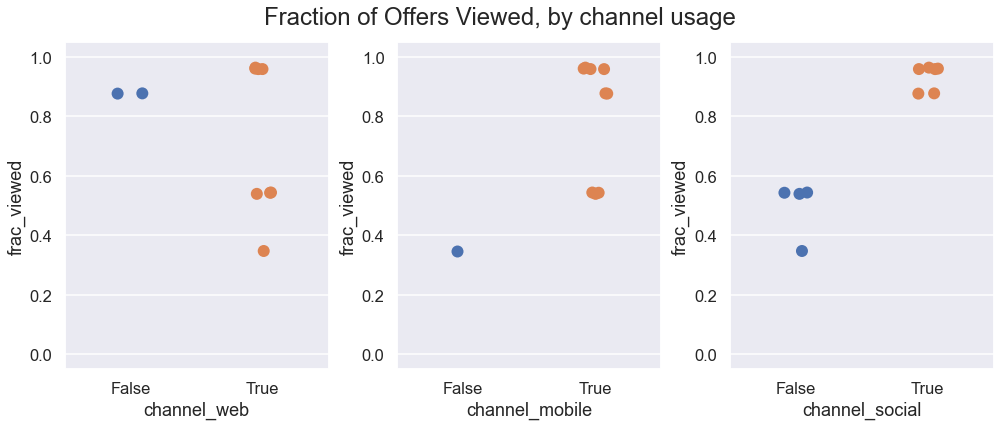

In [64]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
axs=axs.flatten()

sns.stripplot(data=portfolio_extended, x='channel_web', y='frac_viewed', ax=axs[0], s=12)
sns.stripplot(data=portfolio_extended, x='channel_mobile', y='frac_viewed', ax=axs[1], s=12)
sns.stripplot(data=portfolio_extended, x='channel_social', y='frac_viewed', ax=axs[2], s=12)
[ax.set(ylim=[-0.05,1.05]) for ax in axs];

f.suptitle("Fraction of Offers Viewed, by channel usage", fontsize=24)
plt.tight_layout();

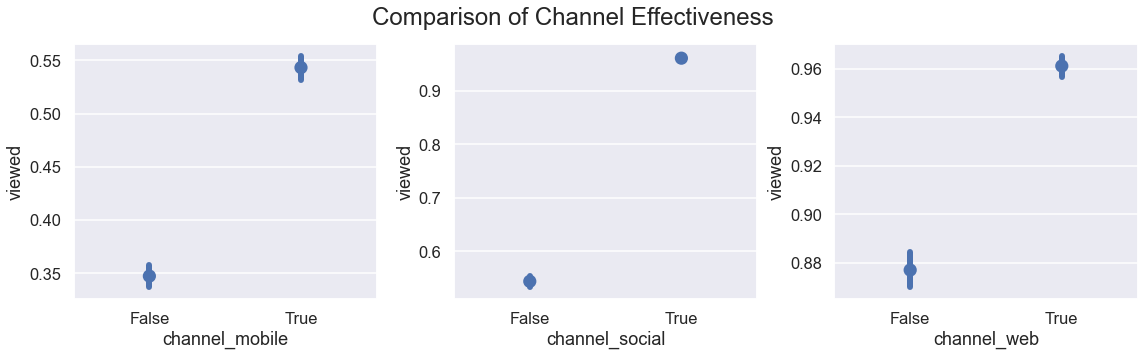

In [65]:
# Make a comparision in view rates for two offers who were identical except for one channel
# and see if Confidence Intervals overlap

# create dictionary of offer pairs which differ in only one channel
                        # for mobile compare disc=20/5/10 vs bogo-5/5/7
channel_checks = {'channel_mobile':['0b1e1539f2cc45b7b9fa7c272da2e1d7', '9b98b8c7a33c4b65b9aebfe6a799e6d9'],
                      # for social compare info-0/0/4 vs bogo-10/10/5
            'channel_social':['3f207df678b143eea3cee63160fa8bed', '4d5c57ea9a6940dd891ad53e9dbe8da0'],
                      # for web compare bogo-10/10/7 vs bogo-10/10/5
            'channel_web': ['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0']}

extended_columns_needed = ['id', 'n_transactions', 'total_amount',
       'n_offers', 'n_offers_viewed', 'n_offers_completed',
       'n_offers_completed_not_viewed', 'frac_viewed', 'frac_completed',
       'frac_completed_unviewed', 'income_binned', 'age_binned',
       'membership_days_binned', 'median_transaction', 'max_transaction',
       'max_transaction_binned', 'max_transaction_no_outliers',
       'max_trans_no_out_binned']


# create temp dataframe with offers, portfolio and profile information all mashed together
offers_df_tmp = pd.merge(offers_df, portfolio, left_on='offer_id', right_on='id', how='left')
offers_df_tmp = pd.merge(offers_df_tmp, profile_extended[extended_columns_needed],
                         left_on='person', right_on='id', how='left')

f, axs = plt.subplots(ncols=3, figsize=(16,5))
axs = axs.flatten()

# plot general channel effectiveness
for i, channel in enumerate(channel_checks.keys()):
    sns.pointplot(data=offers_df_tmp[offers_df_tmp.offer_id.isin(channel_checks[channel])],
             x=channel, y='viewed', join=False, ci=95, errwidth=6, ax=axs[i]);

f.suptitle('Comparison of Channel Effectiveness', fontsize=24)
plt.tight_layout()

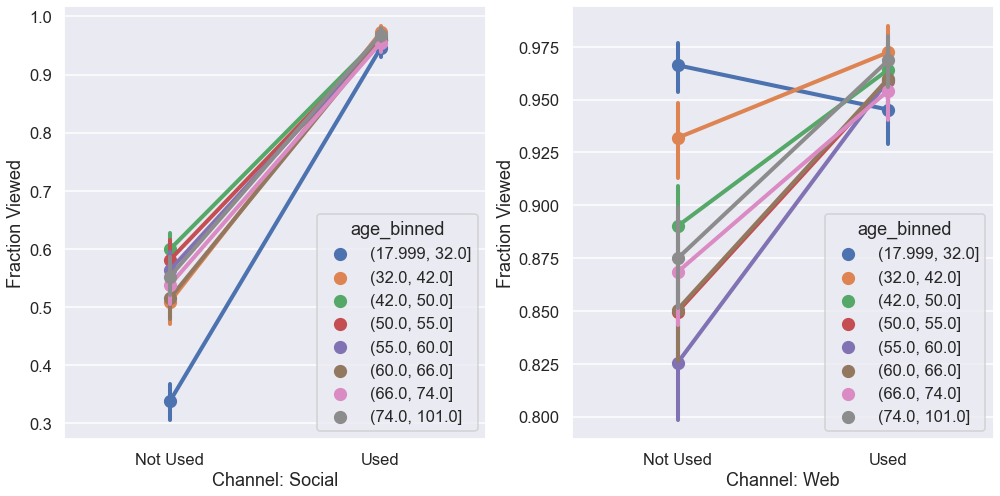

In [66]:
# compare channel effectiveness by age for social and web channels
f, axs = plt.subplots(ncols=2, figsize=(14,7))

sns.pointplot(data=offers_df_tmp[offers_df_tmp.offer_id.isin(channel_checks['channel_social'])],
           x='channel_social', y='viewed', hue='age_binned', hue_order=order_age, ax=axs[0])
axs[0].set(xlabel='Channel: Social', xticklabels=['Not Used', 'Used'], ylabel='Fraction Viewed')

sns.pointplot(data=offers_df_tmp[offers_df_tmp.offer_id.isin(channel_checks['channel_web'])],
           x='channel_web', y='viewed', hue='age_binned', hue_order=order_age, ax=axs[1])
axs[1].set(xlabel='Channel: Web', xticklabels=['Not Used', 'Used'], ylabel='Fraction Viewed')
plt.tight_layout()
plt.savefig('./images/Channel_Performance_by_Age.png', dpi=600);

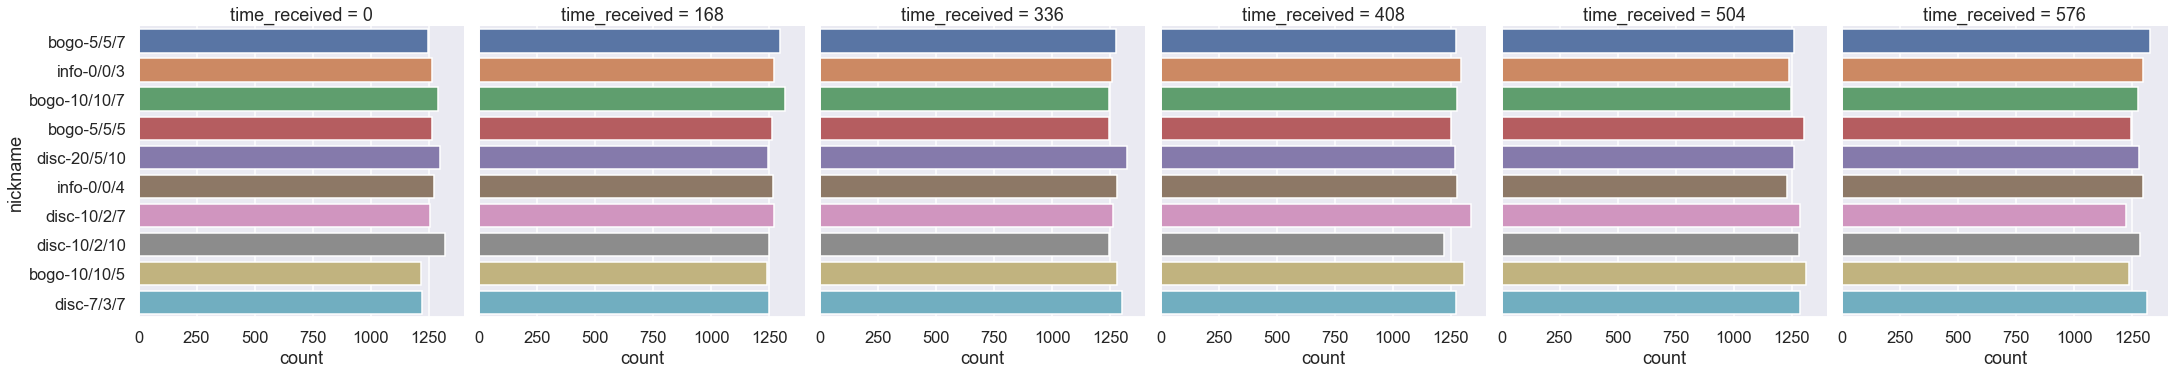

In [67]:
# compare offer send counts at different timepoints
sns.catplot(data=pd.merge(offers_df,
                          portfolio_extended[['id', 'nickname']],
                          left_on='offer_id', right_on='id', how='left'),
            y='nickname', col='time_received', kind='count');

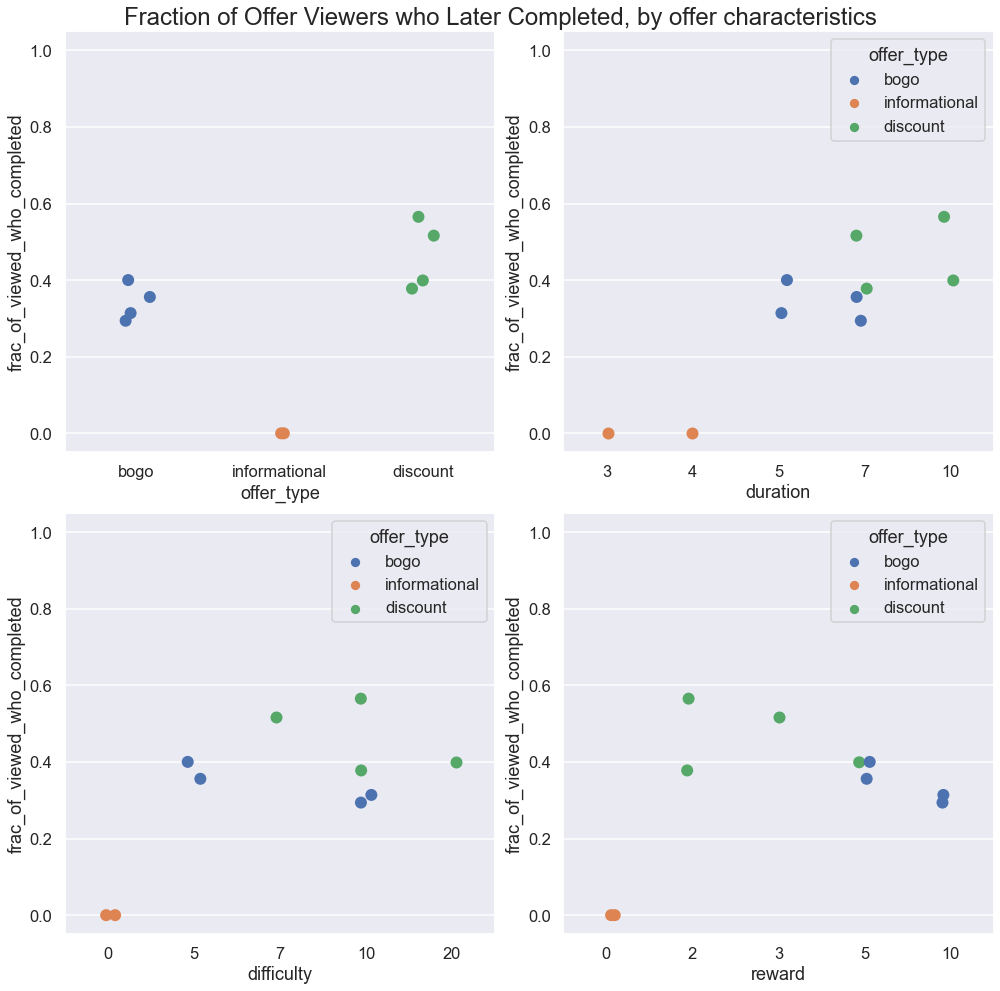

In [68]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
axs=axs.flatten()

sns.stripplot(data=portfolio_extended, x='offer_type', y='frac_of_viewed_who_completed', ax=axs[0], s=12)
sns.stripplot(data=portfolio_extended, x='duration', y='frac_of_viewed_who_completed',
              hue='offer_type', ax=axs[1], s=12)
sns.stripplot(data=portfolio_extended, x='difficulty', y='frac_of_viewed_who_completed',
              hue='offer_type', ax=axs[2], s=12)
sns.stripplot(data=portfolio_extended, x='reward', y='frac_of_viewed_who_completed',
              hue='offer_type', ax=axs[3], s=12)
[ax.set(ylim=[-0.05,1.05]) for ax in axs];

f.suptitle("Fraction of Offer Viewers who Later Completed, by offer characteristics", fontsize=24)
plt.tight_layout();

In [69]:
# This pairwise comparison does not show anything new - but have to plot it to know that
# Commented out as it does not add anything - can uncomment to view

#sns.pairplot(data=portfolio_extended.loc[:,['difficulty', 'duration', 'reward', 'offer_type',
#                                          'frac_viewed', 'frac_completed', 'frac_completed_unviewed']],
#             hue='offer_type', corner=True);

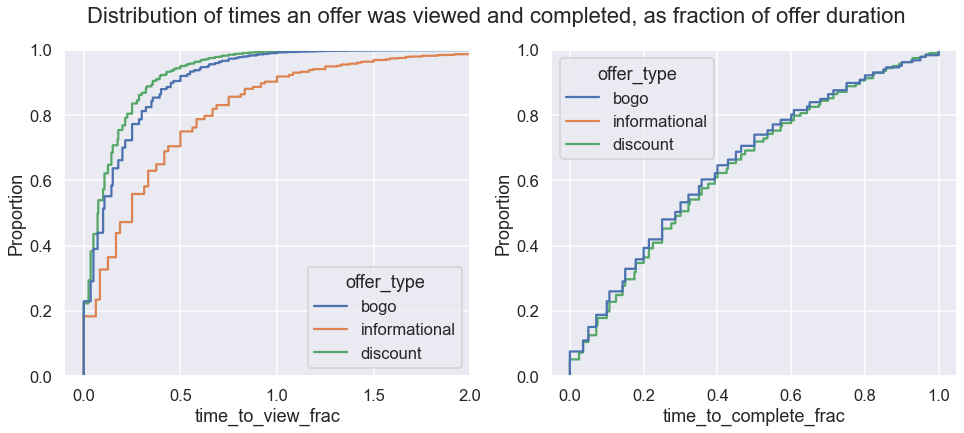

In [70]:
# now looking reversed - bringing the portfolio information into the offers dataframe
# to look at how and when offers are viewed and completed

# bring portfolio information into the offers df and calculate duration fractions
offers_df_ext = pd.merge(offers_df, portfolio, left_on='offer_id', right_on='id', how='left')
offers_df_ext['time_to_view'] = offers_df_ext.time_viewed - offers_df_ext.time_received
offers_df_ext['time_to_view_frac'] = offers_df_ext.time_to_view / (offers_df_ext.duration * 24)
offers_df_ext['time_to_complete'] = offers_df_ext.time_completed - offers_df_ext.time_received
offers_df_ext['time_to_complete_frac'] = offers_df_ext.time_to_complete / (offers_df_ext.duration * 24)
offers_df_ext['view_to_complete_frac'] = \
            (offers_df_ext.time_to_complete - offers_df_ext.time_to_view) / (offers_df_ext.duration * 24)

# plot deliver->view and deliver->complete as a fraction of offer duration
f, axs = plt.subplots(ncols=2, figsize=(16,6))
axs = axs.flatten()
sns.ecdfplot(data=offers_df_ext, x='time_to_view_frac', hue='offer_type', ax=axs[0])
axs[0].set(xlim=[-0.1,2])
sns.ecdfplot(data=offers_df_ext, x='time_to_complete_frac', hue='offer_type', ax=axs[1])
f.suptitle("Distribution of times an offer was viewed and completed, as fraction of offer duration", fontsize=22);

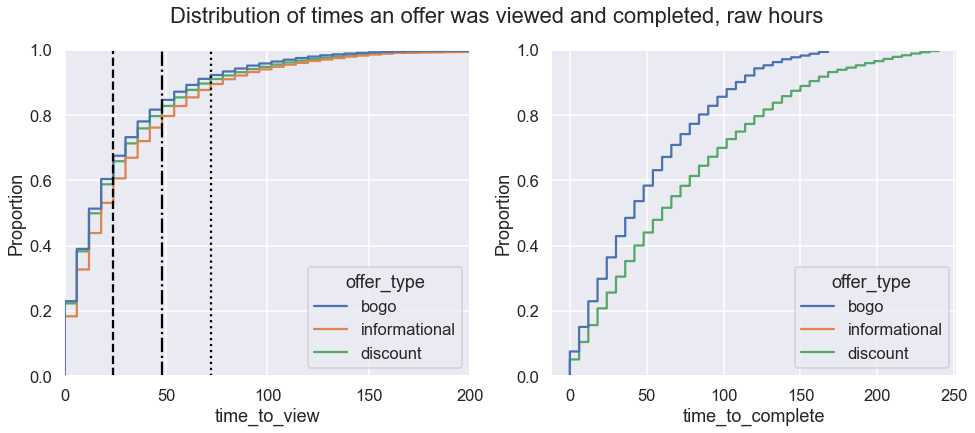

In [71]:
# plot deliver->view and deliver->complete in raw hours
f, axs = plt.subplots(ncols=2, figsize=(16,6))
axs = axs.flatten()

sns.ecdfplot(data=offers_df_ext, x='time_to_view', hue='offer_type', ax=axs[0])
# vertical lines at 24/48/72 hours
axs[0].axvline(24, color='black', ls='--')
axs[0].axvline(48, color='black', ls='-.')
axs[0].axvline(72, color='black', ls=':')
axs[0].set(xlim=[-0.1, 200])
sns.ecdfplot(data=offers_df_ext, x='time_to_complete', hue='offer_type', ax=axs[1])
f.suptitle("Distribution of times an offer was viewed and completed, raw hours", fontsize=22);

## Observations from exploratory data analysis on transcript and portfolio datasets


### Offer Performance

#### Offer Views

Inspection of the performance of the different offers reveals marked difference.  One offer in particular, `0b1e15`, was completed more times without being viewed (1843) than it was after being viewed (1320)!!  Clearly the rewards given out with this offer are not very effective in bringing customers into the store.  At first glance, this would appear to be a very bad offer.

Upon a closer look, this poor performance is driven primarily by a very low number of views.  For this project, we will assume users do not know the content of an offer before they view it.  While this may seem obvious, with some channels -  users may know the content of an offer before viewing.  The offer's content could be clear from a phone notification on their home screen, the subject line of an email, or a thumbnail on a website without the user actually viewing the offer in-app, opening the email, or clicking on the offer on the website.

When comparing to channel usage, the low view count for offer `0b1e15` makes sense - it uses the fewest channels.  Offers that did not user the mobile and social channels showed much lower view rates than offers that did.  The web channel seems to have a smaller impact, and all offers used the email channel so we can't make any inferences about its effectiveness.

The effectiveness of each channel can be examined more statistically by finding offers which have only 1 difference in the channels used.  Applying this method showed that the confidence intervals do not overlap for any of the differences in view rate and thus the impact of channel usage on offer viewing is statistical for all channels that can be evaluated (social, web, mobile).

#### Offer Attractiveness

Fraction of offers completed is not a good metric to use for evaluating the attractiveness of an offer to a user.  This is because there are dramatic differences in the rate at which an offer is viewed, due to the use of different channels.

Within this particular dataset, the best look at offer attractiveness is the view->complete fraction.  

To be more specific, for a given offer this is:

View->Complete Fraction = (N_Completions - N_Completions_Unviewed - N_Completions_Before_View) / N_Views

Users are not attracted to an offer if they haven't viewed it, so it makes sense to use the number of views in the denominator for this as opposed to the number of total offers.  For the numerator, the number of offer completions needs to be adjusted to account for users who completed the offer without being influenced by it - either by completing it unviewed or by completing it before they viewed it.

Using the view->complete fraction instead of raw offer completion fraction makes the largest difference for 10-day discount offer mentioned earlier (`0b1e15`) but otherwise does not change the offer ranking much:

Observations:
- The 10-for-10 BOGO offers have the lowest view->complete fraction, despite offering the highest total reward.
- Discount offers seem to perform slightly better but the difference is slight and it is difficult to compare because the rest of the parameters are also changing which confounds comparison.

#### Timing of offer view and completion

Users do not distinguish between offer types when opening an offer in terms of time - the 'time_viewed' curves are nearly identical for all offer types.

Characteristics:
- Over 50% of offer views occur in the first day
- Approximately 80% of offer views occur in the first 2 days
- Approximately 90% of offer views occur in the first 3 days

Users do seem make a distinction on offer duration as far as pushing to complete.  The offer completion curves overlay each other when normalized as fraction of offer duration.  This implies the users are somewhat influenced by the remaining time on the offer.

There is a lot of focus in the problem description about users who complete an offer without viewing it.  It is true, there are many offers which are completed and are never viewed.  But this perspective is still too simple.  Among users who viewed and offer and completed the same offer, around 20% of them viewed the offer after completing it.  This scenario must also be considered in terms of whether the user was influenced by the offer.

# Evaluating the Revenue Impact

We will define the offer's "influence period" as 10-days after the offer is sent.  A whole study could be done (and may have been done) to determine what this influence period likely is.  However, that is not the focus at the moment.

10 days is chosen because:
- Shorter durations do not allow comparisons across offers.  Over 10% of 10-day offer completions occur after day 7, so choosing 7 days would exclude a menaingful amount of influence from the longer offers.
- Longer durations heavily limit the dataset.  The offers were sent at 0, 7, 14, 17, 21 and 24 days, and the last transaction is just before day 30.  With a 10-day influence period, the only the day-21 and day-24 campaigns need to be excluded from the analysis.  With a 14-day influence period, the day-17 campaign must be excluded as well which now throws out half the dataset.
- Linking the duration to offer view time instead of offer send time exacerbates the dataset-limiting problem.  If we use 10-days after viewing the offer, likely only the day-0 and day-7 campaigns could be used.
- Choosing influence period = offer duration is an option, but this is not adequate for the informational offers.  Almost all of the views for discount or bogo offers occur during the offer duration.  Informational offers, on the other hand, have almost 10% of the views occurring after the offer duration.  In addition, there is also the option of not sending an offer at all.  What would the 'offer duration' of no offer be?

In [72]:
# For the revenue impact - for this we need to add the control option of not sending an offer

# add in the possibility of no offer to the portfolio dataframe
portfolio = pd.concat([portfolio,
         pd.DataFrame(data=[[0, 0, 4, 'none', 'no_offer', 'no_offer', False, False, False, False]],
                     columns=portfolio.columns)], axis=0)
portfolio

,reward,difficulty,duration,offer_type,id,nickname,channel_web,channel_email,channel_mobile,channel_social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10/10/7,False,True,True,True
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10/10/5,True,True,True,True
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,info-0/0/4,True,True,True,False
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5/5/7,True,True,True,False
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,disc-20/5/10,True,True,False,False
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,disc-7/3/7,True,True,True,True
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,disc-10/2/10,True,True,True,True
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,info-0/0/3,False,True,True,True
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,bogo-5/5/5,True,True,True,True
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,disc-10/2/7,True,True,True,False


In [73]:
# Now we need to add to the dataframe the users who did not get an offer at each batch

# set up a list to store time slices of the dataframe
df_slices = []

# iterate through the campaign times
for time in offers_df.time_received.unique():
    # limit the offers dataframe to the time in question
    df_slice = offers_df[offers_df.time_received == time].copy()
    # get a copy of the users dataframe and set time_received to the current time
    tmp = profile.copy()
    tmp['time_received'] = time
    # left join the current time slice to users dataframe and remove the duplicate ID column
    df_slice = pd.merge(tmp, df_slice, left_on=['id', 'time_received'],
                        right_on=['person', 'time_received'], how='left')
    df_slice.drop(columns=['person'], inplace=True)
    df_slice.rename(columns={'id': 'person'}, inplace=True)
    # all NaNs in the offer info refer to people who did not get an offer (only existed in users dataframe)
    df_slice['offer_id'] = df_slice['offer_id'].fillna('no_offer')
    for column in ['viewed', 'completed', 'completed_not_viewed', 'viewed_after_completed']:
        df_slice[column] = df_slice[column].fillna(False)
    
    df_slices.append(df_slice)
    
offers_df = pd.concat(df_slices, axis=0)
del df_slices
offers_df.shape

(102000, 15)

In [74]:
# establish the offer presentation ID as the index of the current offers DF
offers_df = (offers_df.reset_index().drop(columns='index')
             .reset_index().rename(columns={'index': 'offer_presentation_id'}))

offers_df.head()

,offer_presentation_id,gender,age,person,became_member_on,income,days_of_membership,anonymous,time_received,offer_id,viewed,time_viewed,completed,time_completed,completed_not_viewed,viewed_after_completed
0,0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,0,no_offer,False,NaN,False,NaN,False,False
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,0,no_offer,False,NaN,False,NaN,False,False
2,2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,0,no_offer,False,NaN,False,NaN,False,False
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,6.0,True,132.0,False,False
4,4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,True,6.0,False,NaN,False,False


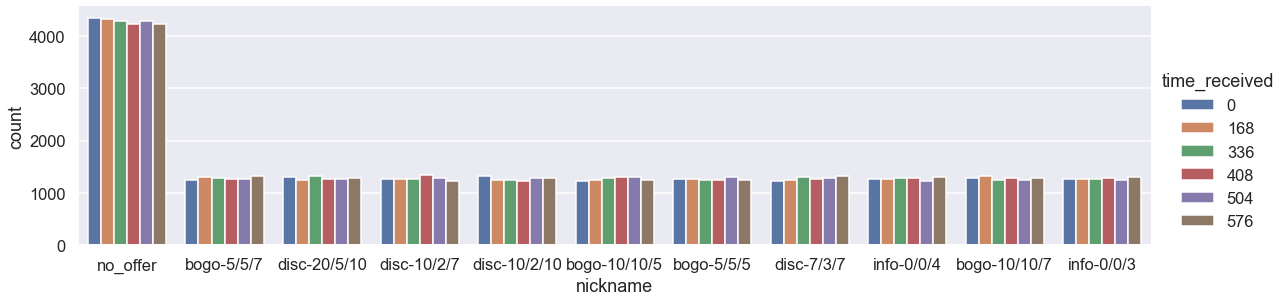

In [75]:
# look at number of offer presentations again, now including the control 'no_offer' option

sns.catplot(data=pd.merge(offers_df,
                          portfolio_extended[['id', 'nickname']],
                          left_on='offer_id', right_on='id', how='left').fillna('no_offer'),
            x='nickname', hue='time_received', kind='count', aspect=4, height=4);

In [76]:
# Now we are ready to calculate the ten-day revenue and ten-day rewards for each offer,
# as well as the revenue and rewards over the duration of each offer

# establish a dictionary to hold the results
dict_ten_day_revenues = {'person':[], 'time_received': [], 'ten_day_revenue': [], 'ten_day_rewards': [],
                        'duration_revenue': [], 'duration_rewards': []}

# perform upfront filtering once to reduce load in the loop
transcript_transactions = transcript[((transcript.event=='transaction') & (~transcript.outlier)) |
                                     (transcript.event=='offer completed')]


#iterate through the people
for person in progressbar.progressbar(profile.id):
    #pull this person's transactions transcript
    transcript_person = transcript_transactions[transcript_transactions.person==person].copy().sort_index()
    # initialize results for each offer delivery time
    ten_day_revenues_person = {0: 0.0, 168:0.0, 336:0.0, 408:0.0, 504:0.0, 576:0.0}
    duration_revenues_person = {0: 0.0, 168:0.0, 336:0.0, 408:0.0, 504:0.0, 576:0.0}
    ten_day_rewards_person = {0: 0.0, 168:0.0, 336:0.0, 408:0.0, 504:0.0, 576:0.0}
    duration_rewards_person = {0: 0.0, 168:0.0, 336:0.0, 408:0.0, 504:0.0, 576:0.0}
    durations_person = pd.merge(offers_df[offers_df.person==person][['time_received', 'offer_id']],
                               portfolio[['id', 'duration']], left_on='offer_id', right_on='id',
                                how='left').set_index('time_received')['duration'].to_dict()
    # iterate through the rows in the transcript
    for _, tmp in transcript_person.iterrows():
        # iterate through delivery times
        for delivery_time in ten_day_revenues_person.keys():
            # if after delivery time and before delivery_time + 10
            if tmp.time >= delivery_time and tmp.time <= (delivery_time + 24*10):
                if tmp.event == 'transaction':
                    # add to the ten_day_revenue for this delivery time
                    ten_day_revenues_person[delivery_time] += tmp.amount
                    # if the time is also less than the duration, add to duration_revenue
                    if tmp.time <= delivery_time + durations_person[delivery_time] * 24:
                        duration_revenues_person[delivery_time] += tmp.amount 
                else:
                    # if not a transaction, must be a completion
                    # add to ten_day_rewards
                    ten_day_rewards_person[delivery_time] += tmp.reward
                    # if also less than duration, add to duration rewards
                    if tmp.time <= delivery_time + durations_person[delivery_time] * 24:
                        duration_rewards_person[delivery_time] += tmp.reward
                        
    #unroll into results dict
    for delivery_time in ten_day_revenues_person.keys():
        dict_ten_day_revenues['person'].append(person)
        dict_ten_day_revenues['time_received'].append(delivery_time)
        dict_ten_day_revenues['ten_day_revenue'].append(ten_day_revenues_person[delivery_time])
        dict_ten_day_revenues['ten_day_rewards'].append(ten_day_rewards_person[delivery_time])
        dict_ten_day_revenues['duration_revenue'].append(duration_revenues_person[delivery_time])
        dict_ten_day_revenues['duration_rewards'].append(duration_rewards_person[delivery_time])

100% (17000 of 17000) |##################| Elapsed Time: 0:06:15 Time:  0:06:15


In [77]:
ten_day_revenues = pd.DataFrame.from_dict(dict_ten_day_revenues)
del dict_ten_day_revenues
ten_day_revenues.head()

,person,time_received,ten_day_revenue,ten_day_rewards,duration_revenue,duration_rewards
0,68be06ca386d4c31939f3a4f0e3dd783,0,0.00,0.0,0.00,0.0
1,68be06ca386d4c31939f3a4f0e3dd783,168,0.35,0.0,0.00,0.0
2,68be06ca386d4c31939f3a4f0e3dd783,336,10.52,5.0,10.52,5.0
3,68be06ca386d4c31939f3a4f0e3dd783,408,14.84,5.0,14.84,5.0
4,68be06ca386d4c31939f3a4f0e3dd783,504,17.42,5.0,12.21,5.0


In [78]:
# create an attractive view of the final offers dataframe to show
person_1 = profile.iloc[43].id
person_2 = profile.iloc[110].id
offers_rev_disp = (pd.merge(offers_df, ten_day_revenues, on=['person', 'time_received'], how='left')
                      .sort_values(['person', 'time_received'])).reset_index().drop(columns='index')
offers_rev_disp = offers_rev_disp[offers_rev_disp.person.isin([person_1, person_2])]
offers_rev_disp = pd.merge(offers_rev_disp, portfolio[['id', 'nickname']],
                           left_on='offer_id', right_on='id', how='left')
nicknames = ['Jane']*6 + ['Noah']*2
offers_rev_disp['person'] = offers_rev_disp.person.str.slice(stop=7) + " ... (" + pd.Series(nicknames) + ")"
offers_rev_disp['offer_id'] = offers_rev_disp.offer_id.str.slice(stop=8) + " ... (" + offers_rev_disp.nickname + ")"
offers_rev_disp[['person', 'offer_id', 'time_received', 'viewed', 'time_viewed',
                 'completed', 'time_completed', 'ten_day_revenue', 'ten_day_rewards']].head(8)

,person,offer_id,time_received,viewed,time_viewed,completed,time_completed,ten_day_revenue,ten_day_rewards
0,8b70ca1 ... (Jane),2906b810 ... (disc-10/2/7),0,False,NaN,True,168.0,56.69,2.0
1,8b70ca1 ... (Jane),no_offer ... (no_offer),168,False,NaN,False,NaN,159.16,12.0
2,8b70ca1 ... (Jane),4d5c57ea ... (bogo-10/10/5),336,True,372.0,True,354.0,104.50,18.0
3,8b70ca1 ... (Jane),f19421c1 ... (bogo-5/5/5),408,True,414.0,False,NaN,75.27,8.0
4,8b70ca1 ... (Jane),2298d6c3 ... (disc-7/3/7),504,True,528.0,True,558.0,75.27,8.0
5,8b70ca1 ... (Jane),9b98b8c7 ... (bogo-5/5/7),576,True,618.0,True,576.0,46.24,5.0
6,94f14dc ... (Noah),4d5c57ea ... (bogo-10/10/5),0,True,30.0,True,54.0,47.64,20.0
7,94f14dc ... (Noah),ae264e36 ... (bogo-10/10/7),168,False,NaN,True,216.0,27.42,10.0


In [79]:
# bring the ten day revenues into the offers dataframe, and add offer portfolio info
offers_rev = pd.merge(offers_df, ten_day_revenues, on=['person', 'time_received'], how='left')
offers_rev = pd.merge(offers_rev, portfolio, left_on='offer_id', right_on='id', how='left').drop(columns='id')
del ten_day_revenues
offers_rev.head()

,offer_presentation_id,gender,age,person,became_member_on,income,days_of_membership,anonymous,time_received,offer_id,...,duration_rewards,reward,difficulty,duration,offer_type,nickname,channel_web,channel_email,channel_mobile,channel_social
0,0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,529,True,0,no_offer,...,0.0,0,0,4,none,no_offer,False,False,False,False
1,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,False,0,no_offer,...,0.0,0,0,4,none,no_offer,False,False,False,False
2,2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14,True,0,no_offer,...,0.0,0,0,4,none,no_offer,False,False,False,False
3,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,False,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,5,5,7,bogo,bogo-5/5/7,True,True,True,False
4,4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,356,True,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,...,0.0,5,20,10,discount,disc-20/5/10,True,True,False,False


In [80]:
# calculate the ten-day profit and ten-day profit with offer reward subtracted
offers_rev['ten_day_profit'] = offers_rev.ten_day_revenue * 0.25
offers_rev['ten_day_profit_minus_reward'] = \
        offers_rev.ten_day_revenue * 0.25 - offers_rev.ten_day_rewards
# same calculation over offer duration
offers_rev['duration_profit'] = offers_rev.duration_revenue * 0.25
offers_rev['duration_profit_minus_reward'] = \
        offers_rev.duration_revenue * 0.25 - offers_rev.duration_rewards
# using offer duration gives an advantage to longer offers - normalize by the number of days
offers_rev['daily_revenue'] = offers_rev.duration_revenue / offers_rev.duration
offers_rev['daily_profit'] = offers_rev.duration_profit / offers_rev.duration
offers_rev['daily_profit_minus_reward'] = offers_rev.duration_profit_minus_reward / offers_rev.duration

# Checking the Invariant Metrics

To ensure an even comparison across offers the invariant metrics must be checked to ensure the randomization was proper, then the profit results can be compared across offers.

In [81]:
# For categorical variables, check the proportion of users who fall into the different categories
# Bootstrap random samples from the profiles dataset (of the same size as the average offer)

props = {'gender': {'M':[], 'F':[], 'O':[]},
         'anonymous': {True:[]}
}

# 5000 bootstrap iterations
for i in progressbar.progressbar(range(5000)):
    # sample the average number of copies of the same offer sent
    boot = profile.sample(n=7627, axis=0, replace=True)
    # iterate through the desired columns
    for column in props.keys():
        # group by the column
        boot_grp = boot.groupby(by=column).size()
        # iterate through the values in the column and add to the results
        for value in props[column].keys():
            props[column][value].append(boot_grp[value] / boot_grp.sum())

100% (5000 of 5000) |####################| Elapsed Time: 0:00:13 Time:  0:00:13


In [82]:
# calculate 95% CI bounds for each proportion
props_CI = {
    'male': [np.percentile(props['gender']['M'], 2.5), np.percentile(props['gender']['M'], 97.5)],
    'female': [np.percentile(props['gender']['F'], 2.5), np.percentile(props['gender']['F'], 97.5)],
    'other': [np.percentile(props['gender']['O'], 2.5), np.percentile(props['gender']['O'], 97.5)],
    'anon': [np.percentile(props['anonymous'][True], 2.5), np.percentile(props['anonymous'][True], 97.5)]
}

In [83]:
# calculate overall average
gender_overall = profile.groupby(by='gender')['id'].count()
prop_male_overall = gender_overall['M']/gender_overall.sum()
prop_female_overall = gender_overall['F']/gender_overall.sum()
prop_other_overall = gender_overall['O']/gender_overall.sum()
anon_overall = profile.groupby(by='anonymous')['id'].count()
prop_anon_overall = anon_overall[True]/profile.shape[0]

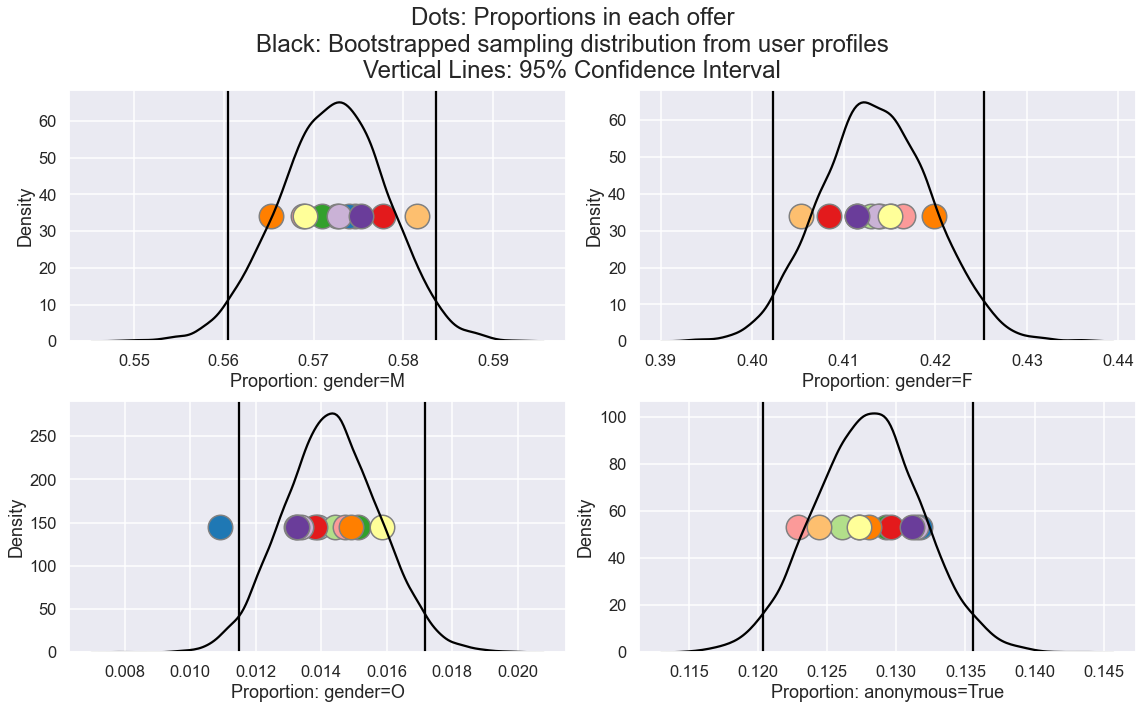

In [84]:
# Plot sampling distributions for each invariant metric
# Add dots for where each offer fell
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
axs = axs.flatten()
palette = sns.color_palette('Paired')

i = 0
# iterate through the categorical variables
for column in props.keys():
    # iterate through the categories for each variable
    for value in props[column].keys():
        # plot the distribution
        sns.kdeplot(data=props[column][value], ax=axs[i], color='black')
        # add 95% CI bounds and label x axis
        axs[i].axvline(np.percentile(props[column][value], 2.5), color='black')
        axs[i].axvline(np.percentile(props[column][value], 97.5), color='black')
        axs[i].set(xlabel='Proportion: ' + str(column) +"=" + str(value))
        # iterate through the offers
        for j, offer in enumerate(portfolio.id.unique()):
            # calculate proportion for the offer and add a dot
            grouped = offers_df[offers_df.offer_id==offer].groupby(column).size()
            axs[i].scatter(grouped[value]/grouped.sum(), np.mean(axs[i].get_ylim()),
                          color=palette[j], s=600, edgecolors='grey')
        i += 1

f.suptitle('Dots: Proportions in each offer\n' + 
           'Black: Bootstrapped sampling distribution from user profiles\n' +
           'Vertical Lines: 95% Confidence Interval', fontsize=24)
plt.tight_layout()

In [85]:
# For the continuous variables, check the means of each variable
# Again use bootstrapping to check
means = {
    'age': [],
    'income': [],
    'days_of_membership': [],
    'median_transaction_no_outliers': []
}

# 5000 bootstrap iterations
for i in progressbar.progressbar(range(5000)):
    # use size of average offer
    boot = profile_extended.sample(n=7627, axis=0, replace=True)
    # add the mean of each continuous variable to list
    for variable in means.keys():
        means[variable].append(boot[variable].mean())

100% (5000 of 5000) |####################| Elapsed Time: 0:00:13 Time:  0:00:13


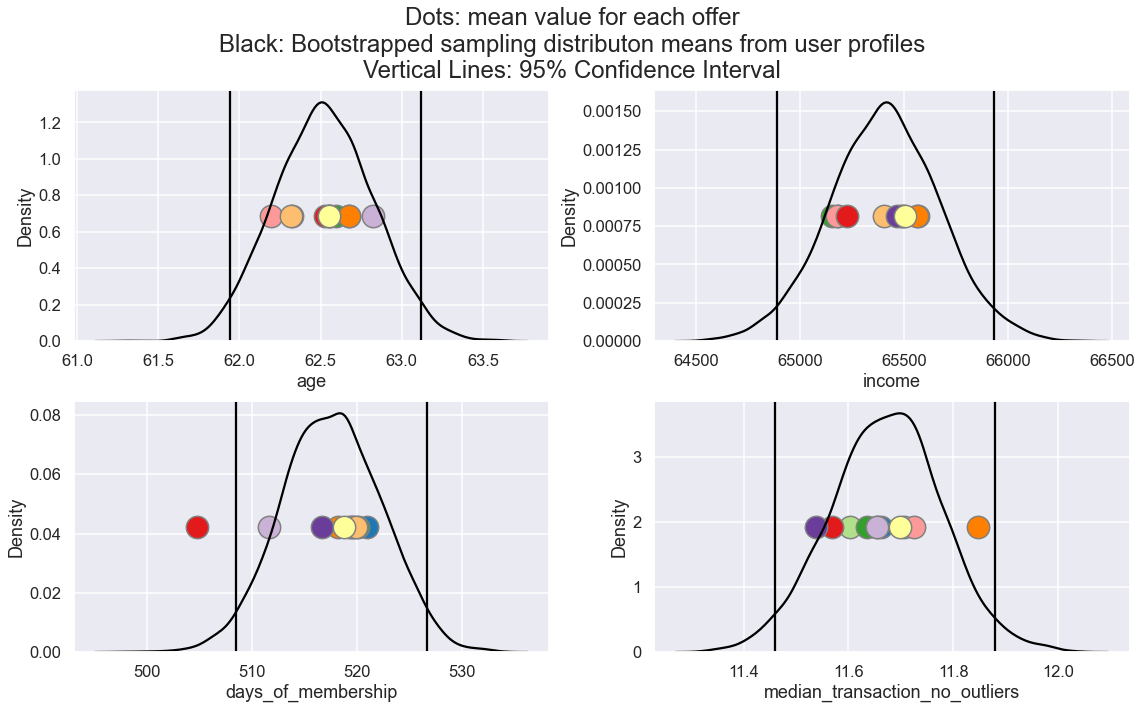

In [86]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axs = axs.flatten()
palette = sns.color_palette('Paired')


# for this plot, add the median transaction data to the offers df so it can be averaged
tmp_plot = pd.merge(offers_df,
                    profile_extended[['id', 'median_transaction_no_outliers']],
                    left_on='person', right_on='id', how='left')

for i, key in enumerate(means.keys()):
    sns.kdeplot(data=means, x=key, ax=axs[i], color='black')
    axs[i].axvline(np.percentile(means[key], 2.5), color='black')
    axs[i].axvline(np.percentile(means[key], 97.5), color='black')
    for j, offer in enumerate(portfolio.id.unique()):
        axs[i].scatter(tmp_plot.loc[tmp_plot.offer_id==offer, key].mean(),
                       np.mean(axs[i].get_ylim()), color=palette[j], s=500, edgecolors='grey')
        
f.suptitle('Dots: mean value for each offer\n' + 
          'Black: Bootstrapped sampling distributon means from user profiles\n' +
          "Vertical Lines: 95% Confidence Interval", fontsize=24)
plt.tight_layout();

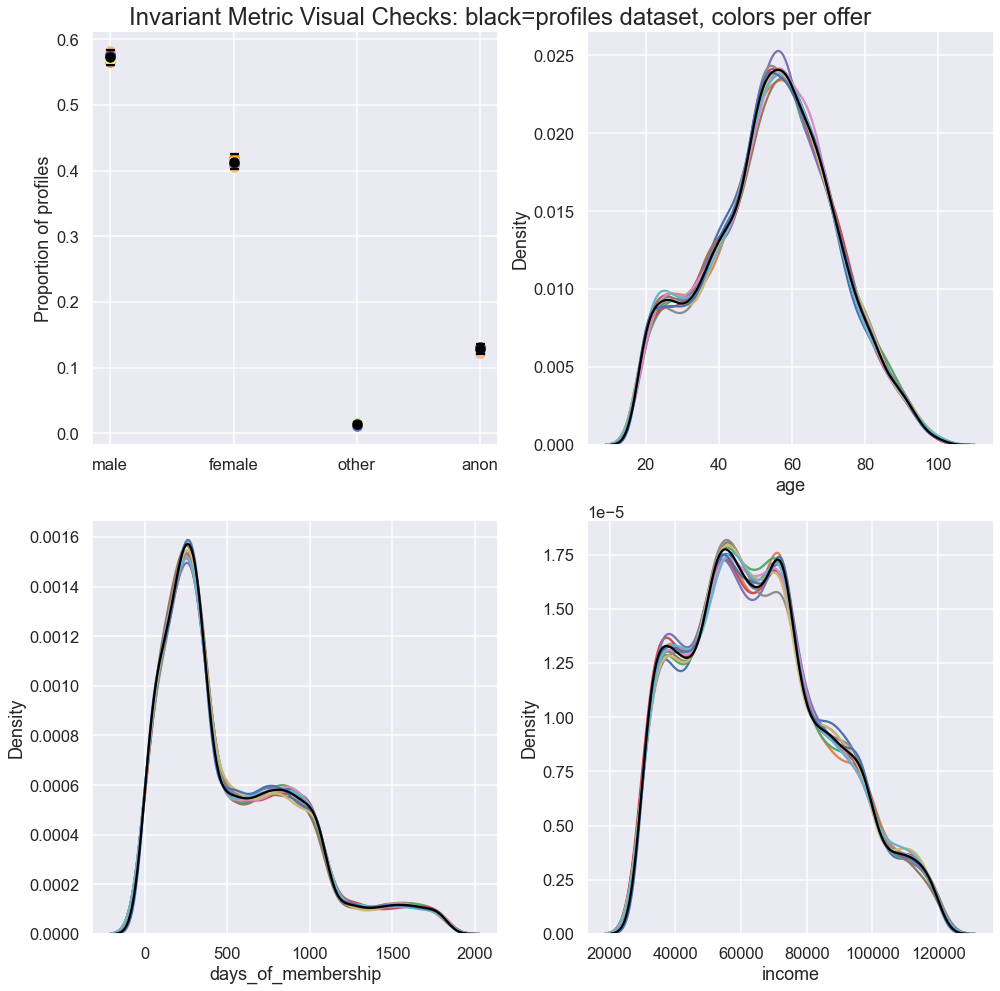

In [87]:
# Generate an attractive overview of the invariant metric checks
# For continuous variables also helps to ensure the whole distribution is consistent
# and not just the mean (anscombe problem)


f, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
axs = axs.flatten()
palette = sns.color_palette('Paired')

# iterate through the offers
for i, offer in enumerate(portfolio.id.values):
    # calculate ratios between groups for the offer and divide by profiles dataset value
    offer_gender = offers_df[offers_df.offer_id==offer].groupby(by='gender').size()
    prop_male = offer_gender['M'] / offer_gender.sum()
    prop_female = offer_gender['F'] / offer_gender.sum()
    prop_other = offer_gender['O'] / offer_gender.sum()
    offer_anon = offers_df[offers_df.offer_id==offer].groupby(by='anonymous').size()
    prop_anon = offer_anon[True] / offer_anon.sum()
    axs[0].scatter(['male', 'female', 'other', 'anon'], 
                   [prop_male, prop_female, prop_other, prop_anon],
                   color=palette[i])
    # density plot of other key profile metrics
    sns.kdeplot(data=offers_df[(offers_df.offer_id==offer) & (~offers_df.anonymous)], x='age', ax=axs[1])
    sns.kdeplot(data=offers_df[offers_df.offer_id==offer], x='days_of_membership', ax=axs[2])
    sns.kdeplot(data=offers_df[offers_df.offer_id==offer], x='income', ax=axs[3])
    
# plot profiles dataset (overall average) values last
# add confidence intervals as horizontal lines
for x_value in props_CI.keys():
    axs[0].scatter([x_value] * 2, props_CI[x_value], color='black', marker="_")
# plot average proportions
axs[0].scatter(['male', 'female', 'other', 'anon'], 
             [prop_male_overall, prop_female_overall, prop_other_overall, prop_anon_overall],
             color='black')
axs[0].set(ylabel='Proportion of profiles')
# plot overall distributions for the continuous variables
sns.kdeplot(data=profile[~profile.anonymous], x='age', ax=axs[1], color='black')
sns.kdeplot(data=profile, x='days_of_membership', ax=axs[2], color='black')
sns.kdeplot(data=profile, x='income', ax=axs[3], color='black')

f.suptitle('Invariant Metric Visual Checks: black=profiles dataset, colors per offer', fontsize=24)
plt.tight_layout();
plt.savefig('./images/Invariant_Metrics_Overview.png')

In [88]:
# clean up data to save memory
del props
del props_CI
del means
del tmp_plot

In [89]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [90]:
portfolio.nickname.unique()

array(['bogo-10/10/7', 'bogo-10/10/5', 'info-0/0/4', 'bogo-5/5/7',
       'disc-20/5/10', 'disc-7/3/7', 'disc-10/2/10', 'info-0/0/3',
       'bogo-5/5/5', 'disc-10/2/7', 'no_offer'], dtype=object)

# Invariant Metric Results


The test generally appears adequate on the invariant metrics.  There are two offers which plot outside the confidence interval on the proportion of gender:Other and on the average account age.  The 10-for-10 BOGO offer is statistically low in proportion of gender=Other and the buy-7-get-3 discount offer is statistically low on membership length.  Otherwise all looks good.  With enough tests some statistically significant variations from the base distribution are to be expected.  These specific offers do not need to be excluded, but if analysis rates them significantly worse or better than the others the potential difference in randomization is a possible reason.

# Offer Performance

In [91]:
# display results in an attractive table for the blog post

# load in the channels list as it will print in a smaller space than the one-hot encoded info
channels = pd.read_json('data/portfolio.json', orient='records', lines=True)[['id', 'channels']]

# merge in the results to the dataframe with no_offer as an option
portfolio_ext_disp = pd.merge(portfolio,
         portfolio_extended[['id', 'frac_viewed', 'frac_completed', 'frac_completed_unviewed',
                             'frac_of_viewed_who_completed']],
         on='id', how='left')
# bring in the original channels column to show offer channels because it is more compact
portfolio_ext_disp = pd.merge(portfolio_ext_disp, channels, on='id', how='left')
# bring in the revenue and profit elements
portfolio_ext_disp = pd.merge(portfolio_ext_disp, 
                              offers_rev.groupby('offer_id')[
                                                                ['ten_day_revenue',
                                                                  'ten_day_profit_minus_reward',
                                                                 'duration_revenue',
                                                                 'duration_profit_minus_reward',
                                                                 'daily_revenue',
                                                                 'daily_profit_minus_reward']].mean(),
                                left_on='id', right_index=True, how='left')

# rename columns to better fit in the table
portfolio_ext_disp.rename(columns={'frac_completed': 'fr_compl',
                          'frac_completed_unviewed': 'fr_compl_unview',
                          'frac_of_viewed_who_completed': 'fr_of_view_who_compl',
                            'daily_revenue': 'daily_rev', 'daily_profit_minus_reward': 'daily_profit_less_reward',
                          'ten_day_revenue': '10d_rev', 'frac_viewed': 'fr_view',
                                'ten_day_profit_minus_reward': '10d_profit_less_reward'}, inplace=True)

In [92]:
# display the 10-day and offer completion data, attractively styled
(portfolio_ext_disp[['nickname', 'channels', 'fr_view',
                     'fr_compl', 'fr_compl_unview',
                    'fr_of_view_who_compl', '10d_rev',
                    '10d_profit_less_reward']]
                    .sort_values('10d_profit_less_reward', ascending=False)
                    .style.background_gradient(axis=0, cmap='vlag'))

,nickname,channels,fr_view,fr_compl,fr_compl_unview,fr_of_view_who_compl,10d_rev,10d_profit_less_reward
6,disc-10/2/10,"['web', 'email', 'mobile', 'social']",0.964460,0.699882,0.154666,0.565306,40.620284,6.735300
7,info-0/0/3,"['email', 'mobile', 'social']",0.877789,0.000000,0.000000,0.000000,28.610413,5.226376
5,disc-7/3/7,"['web', 'email', 'mobile', 'social']",0.959587,0.674340,0.179048,0.516151,36.617372,5.150027
2,info-0/0/4,"['web', 'email', 'mobile']",0.544046,0.000000,0.000000,0.000000,26.721205,4.782441
9,disc-10/2/7,"['web', 'email', 'mobile']",0.539570,0.526336,0.322458,0.377853,30.085831,4.572689
10,no_offer,nan,nan,nan,nan,nan,24.233804,4.175506
8,bogo-5/5/5,"['web', 'email', 'mobile', 'social']",0.959451,0.567428,0.183463,0.400193,32.927443,3.489290
4,disc-20/5/10,"['web', 'email']",0.347287,0.446009,0.307381,0.399174,28.730467,3.011255
3,bogo-5/5/7,"['web', 'email', 'mobile']",0.543311,0.567149,0.373714,0.356030,29.947995,2.719251
0,bogo-10/10/7,"['email', 'mobile', 'social']",0.876991,0.481588,0.223818,0.293925,35.086239,1.986629


In [93]:
# add column to rank the offers on 10d profit, for easier comparison to the daily profit
portfolio_ext_disp['rank_10d'] = portfolio_ext_disp['10d_profit_less_reward'].rank()

# display the same table but with daily-normalized duration revenue and profit
# - As can be seen from the rank column, most of the order remains the same
#.  the info-0/0/3 switches places with the disc-10/2/10
#.  and the info-0/0/4 switches places with the disc-7/3/7

(portfolio_ext_disp[['nickname', 'channels', 'fr_view', 'fr_compl', 'fr_compl_unview',
                    'fr_of_view_who_compl', 'daily_rev', 'daily_profit_less_reward', 'rank_10d']]
                    .sort_values('daily_profit_less_reward', ascending=False)
                    .style.background_gradient(axis=0, cmap='vlag'))

,nickname,channels,fr_view,fr_compl,fr_compl_unview,fr_of_view_who_compl,daily_rev,daily_profit_less_reward,rank_10d
7,info-0/0/3,"['email', 'mobile', 'social']",0.877789,0.000000,0.000000,0.000000,3.965285,0.878868,10.000000
6,disc-10/2/10,"['web', 'email', 'mobile', 'social']",0.964460,0.699882,0.154666,0.565306,4.062028,0.673530,11.000000
2,info-0/0/4,"['web', 'email', 'mobile']",0.544046,0.000000,0.000000,0.000000,3.164292,0.668485,8.000000
5,disc-7/3/7,"['web', 'email', 'mobile', 'social']",0.959587,0.674340,0.179048,0.516151,4.208951,0.597864,9.000000
9,disc-10/2/7,"['web', 'email', 'mobile']",0.539570,0.526336,0.322458,0.377853,3.241456,0.508852,7.000000
10,no_offer,nan,nan,nan,nan,nan,2.370143,0.479058,6.000000
8,bogo-5/5/5,"['web', 'email', 'mobile', 'social']",0.959451,0.567428,0.183463,0.400193,4.185325,0.323705,5.000000
4,disc-20/5/10,"['web', 'email']",0.347287,0.446009,0.307381,0.399174,2.873047,0.301126,4.000000
3,bogo-5/5/7,"['web', 'email', 'mobile']",0.543311,0.567149,0.373714,0.356030,3.218607,0.251162,3.000000
0,bogo-10/10/7,"['email', 'mobile', 'social']",0.876991,0.481588,0.223818,0.293925,3.925412,0.136093,2.000000


In [94]:
# get order to plot offers for consistency across charts

order_offer = (offers_rev
                   .groupby(by='nickname')
                   ['ten_day_profit_minus_reward']
                   .mean()
                   .sort_values(ascending=False)
                   .index)

order_offer_daily = (offers_rev
                   .groupby(by='nickname')
                   ['daily_profit_minus_reward']
                   .mean()
                   .sort_values(ascending=False)
                   .index)

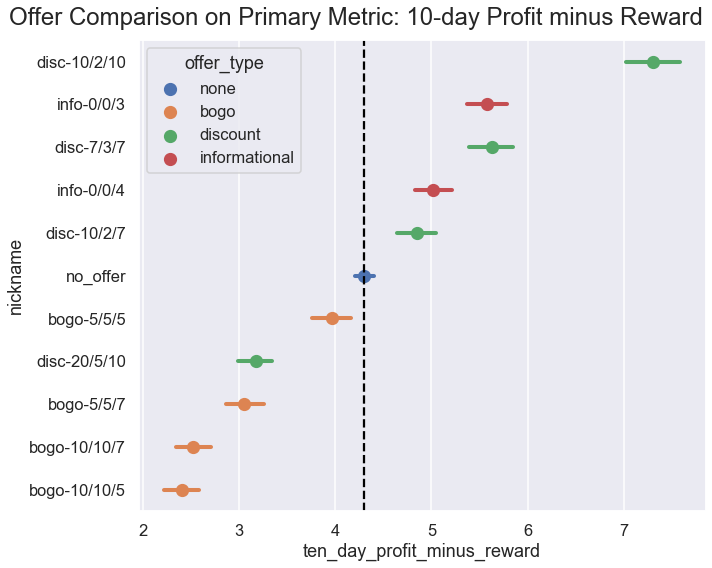

In [95]:
# create base chart - shows offer performance and confidence intervals
# other charts will be based on this
f, ax = plt.subplots(figsize=(10, 8))

sns.pointplot(data=offers_rev[offers_rev.time_received < 500], x='ten_day_profit_minus_reward', y='nickname',
              hue='offer_type', join=False, order=order_offer)
ax.axvline(offers_rev[(offers_rev.offer_id=='no_offer') &
                      (offers_rev.time_received < 500)]['ten_day_profit_minus_reward'].mean(),
           color='black', ls='--',)
f.suptitle('Offer Comparison on Primary Metric: 10-day Profit minus Reward', fontsize=24)
plt.tight_layout();

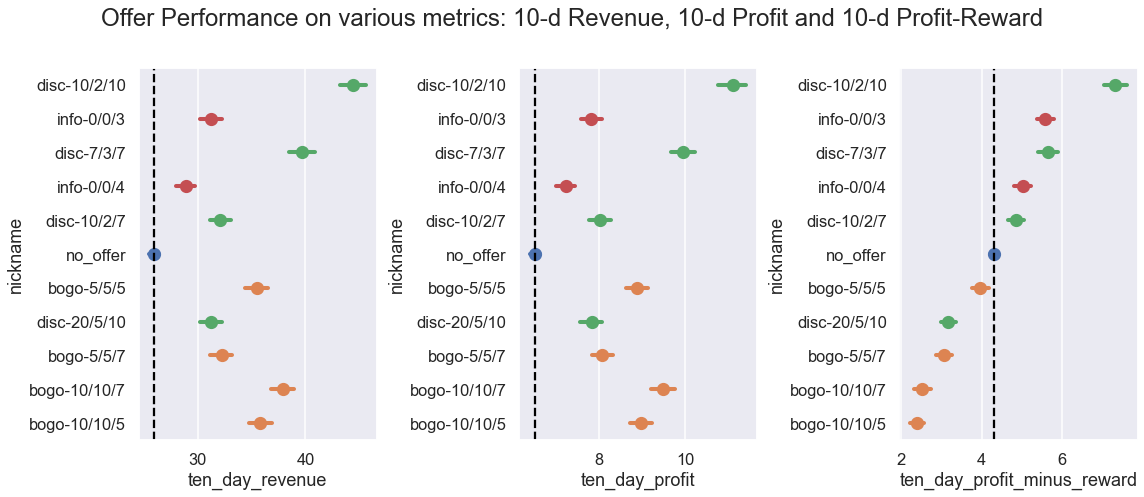

In [96]:
# show the importance of using profit instead of revenue as well as subtracting reward

# create identical plots for revenue, profit and profit-reward to show how ranks change
f, axs = plt.subplots(ncols=3, figsize=(16,7))
axs=axs.flatten()

for i, column in enumerate(['ten_day_revenue', 'ten_day_profit', 'ten_day_profit_minus_reward']):
    sns.pointplot(data=offers_rev[offers_rev.time_received < 500], x=column, y='nickname', hue='offer_type',
                  join=False, ax=axs[i], order=order_offer, legend=False)
    axs[i].axvline(offers_rev[(offers_rev.offer_id=='no_offer') & 
                             (offers_rev.time_received < 500)][column].mean(), color='black', ls='--',)
    axs[i].legend([],[], frameon=False)

f.suptitle('Offer Performance on various metrics: 10-d Revenue, 10-d Profit and 10-d Profit-Reward\n', fontsize=24)
plt.tight_layout();

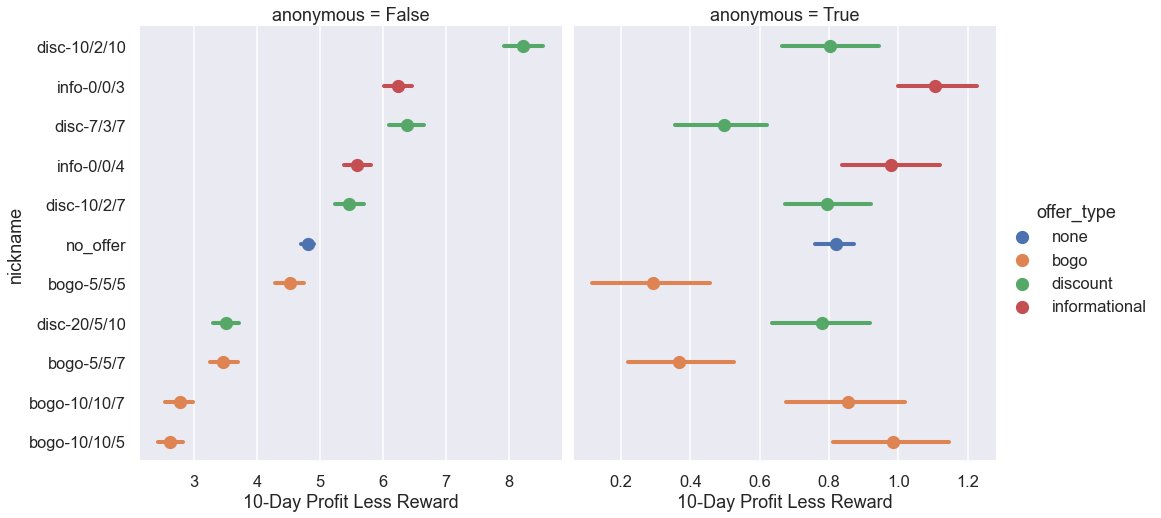

In [97]:
g = sns.catplot(data=offers_rev[offers_rev.time_received < 500], x='ten_day_profit_minus_reward',
            y='nickname', hue='offer_type', kind='point', join=False, col='anonymous', sharex=False, height=7,
           order=order_offer);
g.set_axis_labels('10-Day Profit Less Reward', 'nickname');
g.savefig('./images/Offer_Performance_Anonymous.png', dpi=600)

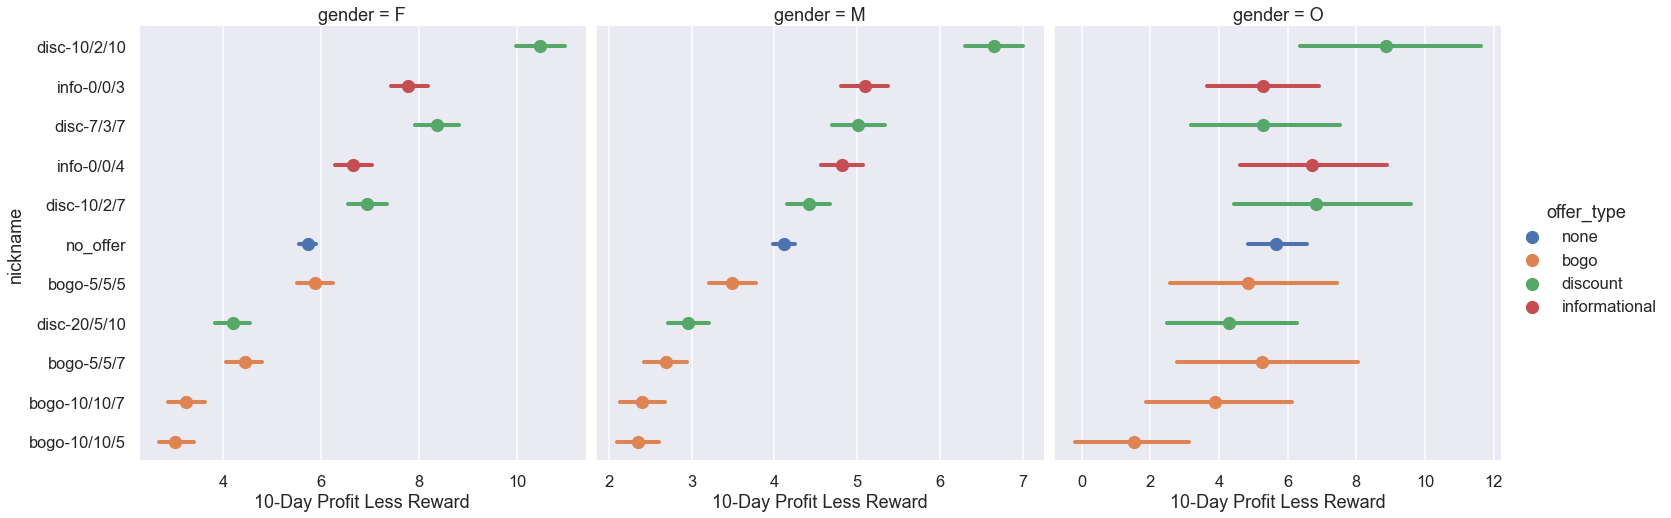

In [98]:
# plot offer performance for different genders - no difference in performance

g = sns.catplot(data=offers_rev[offers_rev.time_received < 500], x='ten_day_profit_minus_reward',
            y='nickname', hue='offer_type', kind='point', join=False, col='gender', sharex=False, height=7,
           order=order_offer);
g.set_axis_labels('10-Day Profit Less Reward', 'nickname');

In [99]:
profile_extended.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income',
       'days_of_membership', 'anonymous', 'median_transaction',
       'max_transaction', 'max_med_trans_ratio', 'max_transaction_binned',
       'median_transaction_binned', 'max_transaction_no_outliers',
       'max_trans_no_out_binned', 'median_transaction_no_outliers',
       'median_trans_no_out_binned', 'has_outlier', 'n_transactions',
       'total_amount', 'n_offers', 'n_offers_viewed', 'n_offers_completed',
       'n_offers_completed_not_viewed', 'frac_viewed', 'frac_completed',
       'frac_completed_unviewed', 'income_binned', 'age_binned',
       'membership_days_binned'],
      dtype='object')

In [100]:
# bring extended profile information into a temporary plot dataframe
#  - mostly binned versions of continuous variables
tmp_plot = pd.merge(offers_rev, profile_extended[['id', 'age_binned', 'membership_days_binned', 'has_outlier',
                                                  'income_binned', 'max_trans_no_out_binned',
                                                 'median_trans_no_out_binned']],
                   left_on='person', right_on='id', how='left')

In [101]:
# No major takeaways from comparison with age.  Commented out for notebook performance.
# Can uncomment to see for yourself.

#sns.catplot(data=tmp_plot[tmp_plot.time_received < 500], x='ten_day_profit_minus_reward',
#            y='nickname', hue='offer_type', kind='point', join=False, col='age_binned', col_order=order_age,
#            order=order_offer,
#            col_wrap=2, sharex=False, height=7);

In [102]:
# plot offer performance vs whether the user has an outlier transaction
# nothing new here - commented out for notebook performance
# can uncomment to see for yourself

#sns.catplot(data=tmp_plot[tmp_plot.time_received < 500], x='ten_day_profit_minus_reward',
#            y='nickname', hue='offer_type', kind='point', join=False, col='has_outlier',
#            order=order_offer,
#            col_wrap=2, sharex=False, height=7);

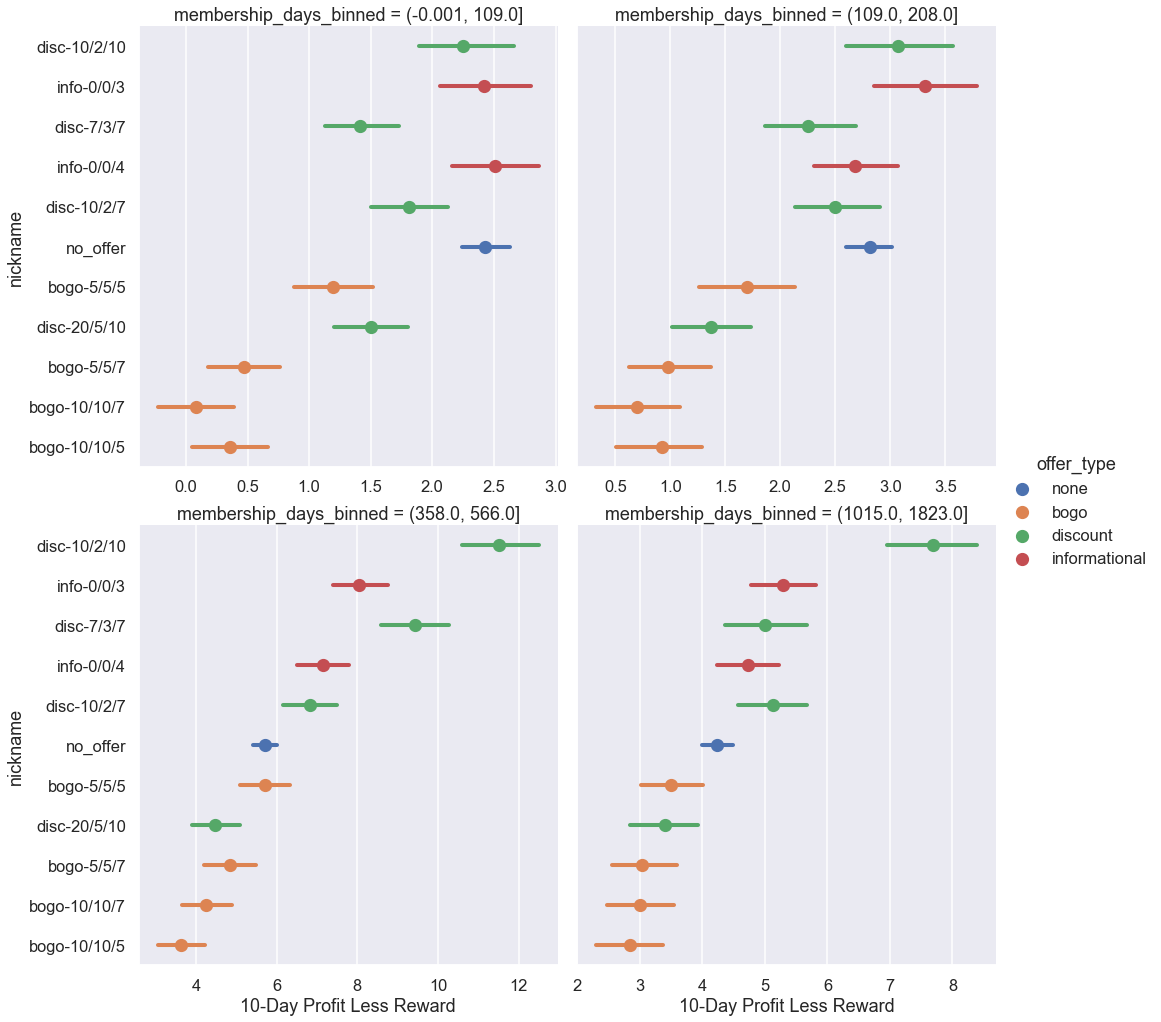

In [103]:
# plot offer performance vs membership length for the blog post
# nicer axes titles, limit to a subset of the bins

selected_bins = ['(-0.001, 109.0]', '(109.0, 208.0]', '(358.0, 566.0]', '(1015.0, 1823.0]']
order_selected = [x for x in order_membership if str(x) in selected_bins]

g = sns.catplot(data=tmp_plot[(tmp_plot.time_received < 500) & 
                          (tmp_plot.membership_days_binned.astype(str).isin(selected_bins))],
            x='ten_day_profit_minus_reward',
            y='nickname', hue='offer_type', kind='point', join=False, col='membership_days_binned',
            order = order_offer,
            col_order=order_selected, col_wrap=2, sharex=False, height=7);

g.set_axis_labels('10-Day Profit Less Reward', 'nickname');
g.savefig('./images/Offer_Performance_Membership.png', dpi=600)

In [104]:
# nothing major from plotting ten day profit vs income - 
# the "star" offer still the best across all income levels (with some variation below)

#sns.catplot(data=tmp_plot[tmp_plot.time_received < 500], x='ten_day_profit_no_out_minus_reward',
#            y='offer_id_short', hue='offer_type', kind='point', join=False, col='income_binned',
#            col_order=order_income, col_wrap=2, sharex=False, height=7);

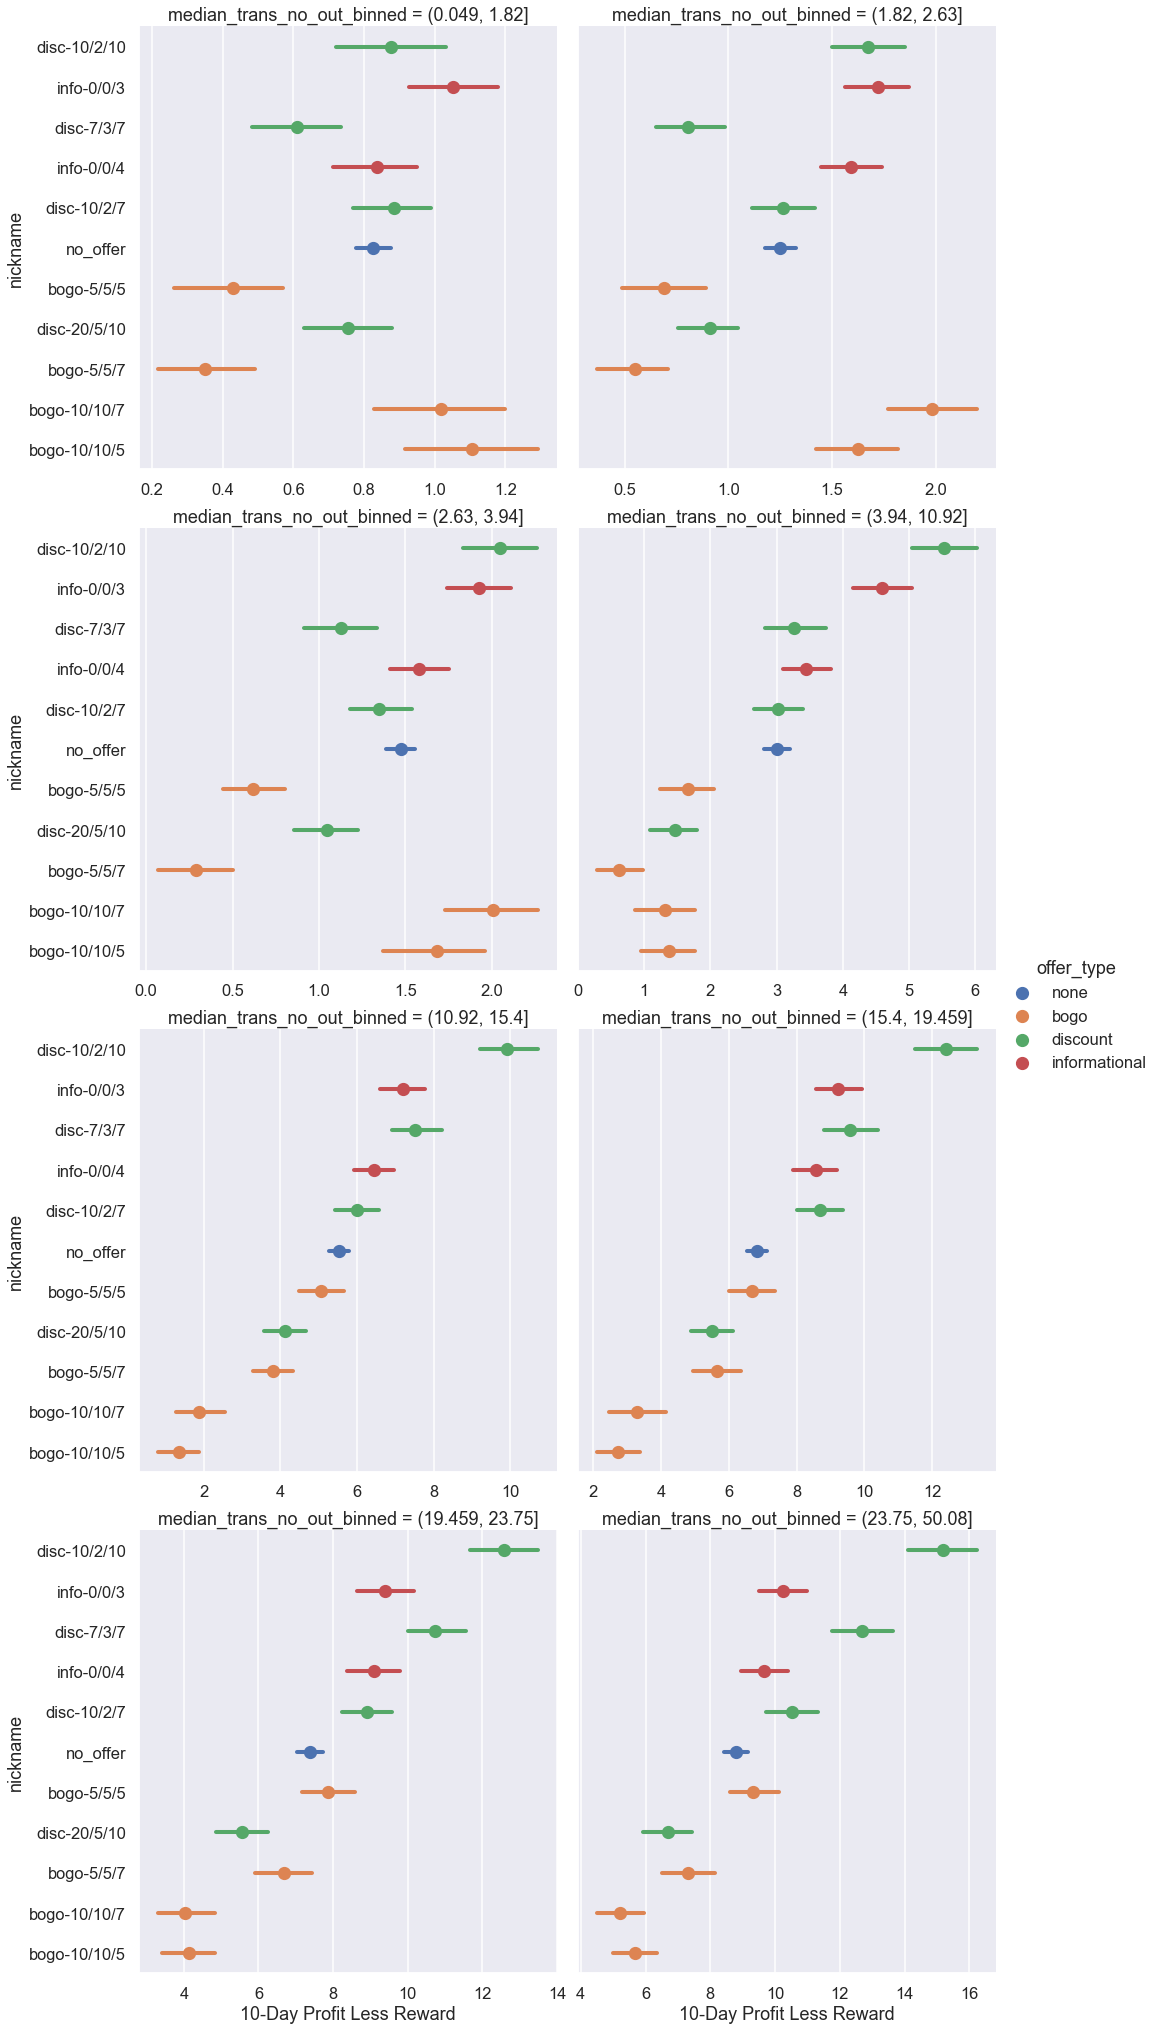

In [105]:
# Offer performance against median transaction

g = sns.catplot(data=tmp_plot[(tmp_plot.time_received < 500)],
            x='ten_day_profit_minus_reward',
            y='nickname', hue='offer_type', kind='point', join=False, col='median_trans_no_out_binned',
            order=order_offer,
            col_wrap=2, sharex=False, height=7);

g.set_axis_labels('10-Day Profit Less Reward', 'nickname');

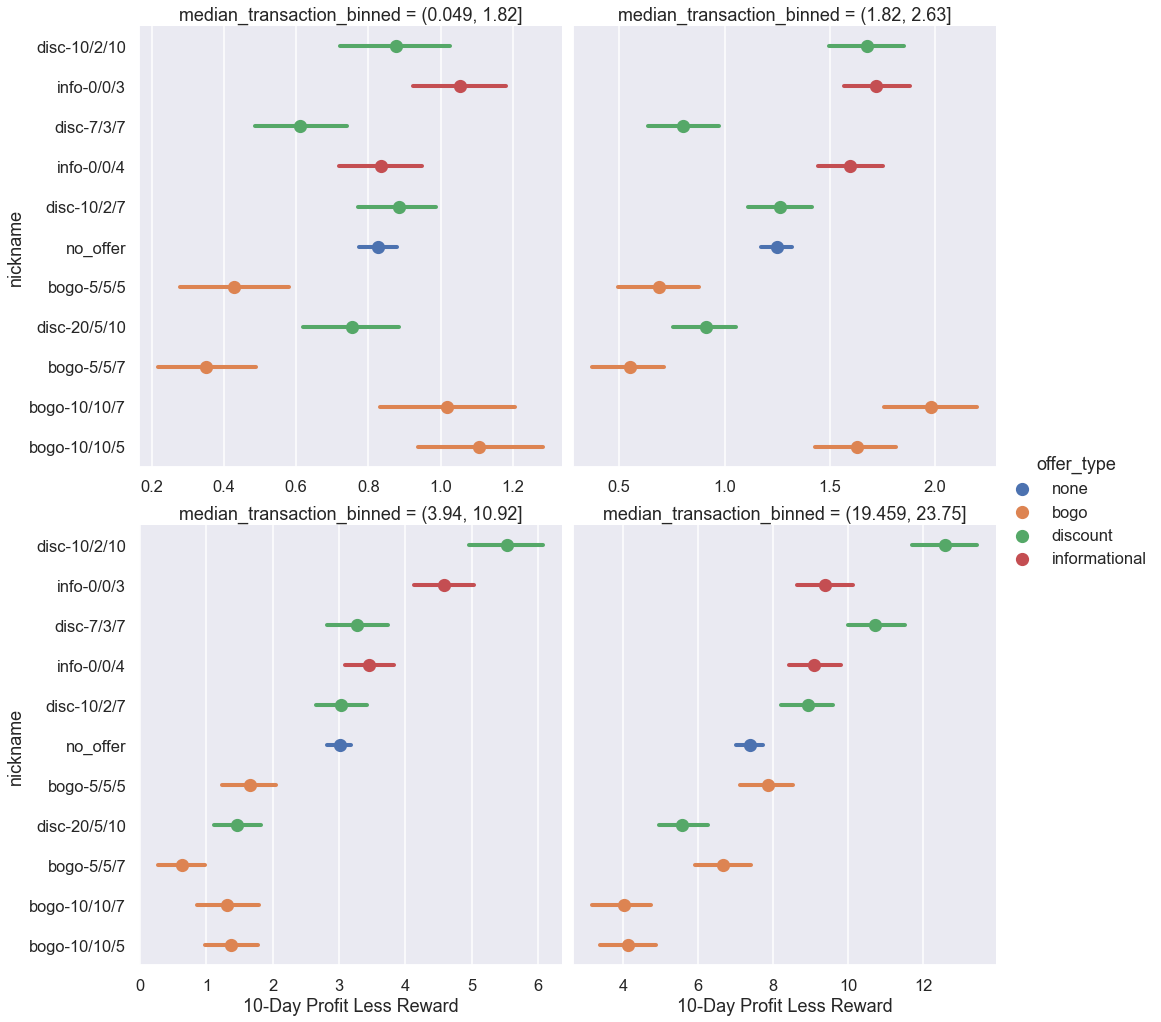

In [106]:
# plot offer performance vs median transaction for the blog post
# edit axes names/titles and only plot a subset of the bins so it's not too long

selected_bins = ['(0.049, 1.82]', '(1.82, 2.63]', '(3.94, 10.92]', '(19.459, 23.75]']
order_selected = [x for x in tmp_plot.median_trans_no_out_binned.unique().sort_values() if str(x) in selected_bins]

g = sns.catplot(data=(tmp_plot[(tmp_plot.time_received < 500) &
                         (tmp_plot.median_trans_no_out_binned.astype(str).isin(selected_bins))]
                         .rename(columns={'median_trans_no_out_binned': 'median_transaction_binned'})),
            x='ten_day_profit_minus_reward',
            y='nickname', hue='offer_type', kind='point', join=False, col='median_transaction_binned',
            order=order_offer,
            col_wrap=2, col_order=order_selected, sharex=False, height=7);

g.set_axis_labels('10-Day Profit Less Reward', 'nickname');
g.savefig('./images/Offer_Performance_Median_Transaction.png', dpi=600)

In [107]:
# no insights from this plot - ten day revenue vs max transaction
# commented out but can uncomment to see


#sns.catplot(data=tmp_plot[tmp_plot.time_received < 500], x='ten_day_profit_no_out_minus_reward',
#            y='offer_id_short', hue='offer_type', kind='point', join=False, col='max_trans_no_out_binned',
#            col_wrap=2, sharex=False, height=7);

# Insights from Analysis as an A/B Test


The best-performing offer in the data is the spend-10-get-2 discount offer, valid for 10 days.  This offer drove a lot of completions, generated a lot of 10d revenue and has a low cost in terms of reward.  The informational offers also do reasonably well, driving an increase in revenue with no required reward spend.

The recommendations to Stuckbars for offer choice are:

- For anonymous users, send _informational offers_

- For customers with < 6mo of membership, send _informational offers_, _no offer_ or the top _disc-10/2/10_ offer.

- For customers who normally spend <~\\$2.50, send one of the _10-for-10 bogo offers_.

- For all other customers, send the _disc-10/2/10 offer_ (best performing overall)

In [108]:
# pickle processed dataframes as input to machine learning extension
offers_rev.to_pickle('./data/offers_rev.pkl')
profile_extended.to_pickle('./data/profile_extended.pkl')
portfolio_extended.to_pickle('./data/portfolio_extended.pkl')
portfolio.to_pickle('./data/portfolio.pkl')